In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from collections import OrderedDict
import copy
import csv
import re
import seaborn as sns
import sklearn

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from statsmodels.tsa.api import VAR
import statsmodels.api as sm


np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

import warnings
warnings.filterwarnings("ignore")

image_folder = "figures/"
include_plot_title = False

%matplotlib inline

In [2]:
os.chdir('..')
%pwd

'D:\\coding\\bonita\\data200_grad_project\\3036322522_3034256606_3032913509'

## Data Source

We utilized two data sets in our project. The first data set is the USA daily state reports and Provisional COVID-19 Deaths by Sex and Age. 

The USA daily state reports are provided by the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. The data set provides 20 features and has a total of 20550 entries. It is an aggregation of multiple data sources, from organizations such as World Health Organization (WHO), European Centre for Disease Prevention and Control (ECDC), DXY.cn, US CDC, BNO News, WorldoMeters, 1Point3Acres, COVID Tracking Project, Los Angeles Times, The Mercury Times, and data from US state department or at county/city level. Since the way each data source collect their data may vary, there might be some inconsistencies and differences in the data from each source. For our project, we included the state name, time each entry was last updated, latitude, longitude, number of confirmed COVID-19 cases, number of COVID-19 deaths, and number of active cases, which is the number of confirmed cases that have not been resolved (total cases - total recovered - total deaths). 

The Provisional COVID-19 Deaths by Sex and Age is provided by National Center for Health Statistics (NCHS). The data is collected by death certificates submitted to NCHS. Because the number of death is only recorded as the number received as of the date of analysis, it may not match the actual number. This causes incomplete data because of the time difference between the actual death and the making of death certificates. This lag may range from 1 week to 8 weeks or more. The data set contains 16 different features and a total of 41310 rows. Features we chose to pay attention to include state, year, month, sex, age group, number of deaths by COVID-19, and number of total deaths. During data cleaning, we removed “United States” and “New York City” from the states column, since they are not states. For the age column we removed “All Ages”, and for the sex column we removed “All Sexes” to avoid double counting. There were also many different age groups. For our case, we labeled people from groups 65 - 74 and 75 - 84 as old. Finally, we grouped the data into weeks, instead of months as we had initially intended for, so we had more data points.

In [3]:
df_daily = pd.read_csv("data/csse_covid_19_daily_reports_us.csv")
df_daily.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate,People_Tested,Mortality_Rate
0,Alabama,US,2021-01-02 05:30:44,32.3182,-86.9023,365747,4872,202137.0,158738.0,1.0,7459.375895,1885216.0,NaN,1.332068,84000001.0,USA,38448.804196,NaN,NaN,NaN
1,Alaska,US,2021-01-02 05:30:44,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN,NaN,NaN
2,American Samoa,US,2021-01-02 05:30:44,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN,NaN,NaN
3,Arizona,US,2021-01-02 05:30:44,33.7298,-111.4312,530267,9015,76934.0,444318.0,4.0,7285.171274,5155330.0,NaN,1.700087,84000004.0,USA,39551.860582,NaN,NaN,NaN
4,Arkansas,US,2021-01-02 05:30:44,34.9697,-92.3731,229442,3711,199247.0,26484.0,5.0,7602.945718,2051488.0,NaN,1.617402,84000005.0,USA,67979.497674,NaN,NaN,NaN


In [4]:
df_age = pd.read_csv("data/cdc_death_counts_by_sex_age_state.csv")
df_age.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,All Ages,533291.0,4103982.0,460433.0,259678.0,9020.0,741824.0,NaN
1,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,Under 1 year,57.0,22249.0,241.0,8.0,21.0,311.0,NaN
2,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,0-17 years,246.0,38993.0,658.0,44.0,179.0,1039.0,NaN
3,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,1-4 years,31.0,4010.0,136.0,5.0,61.0,223.0,NaN
4,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,5-14 years,87.0,6479.0,192.0,19.0,76.0,336.0,NaN


## Data Cleaning

We removed FIPS (Federal Information Processing Standards) code that uniquely identifies counties within the USA, since there was only one per state in almost all cases, making it uninformative. We also removed the cruises, i.e. Diamond Princess and Grand Princess, since they are not US states. We removed a state called “Recovered” which had mostly NaN or 0 values, and thus we concluded it was a typo. We converted the time each entry was last updated to datetime object for easier manipulation. We removed entries that have negative active dates because the number of total cases should not be smaller than the number of recovered cases and the number of deaths. Furthermore, we remove rows with missing dates. Some number of deaths in the data set were negative. For deaths between -5 and 0 we mark them with 0, and for deaths less than -5 we replace the value with NaN. After the preliminary data cleaning, we have 19732 samples for this data set, with the following columns: “Province\_State", “Last\_Update", “Lat", “Long", “Confirmed", “Deaths", and “Active". 

We computed the difference between deaths and confirmed cases in the source because the given values were cumulative. The difference between a date's value and the previous date's value would yield the daily cases or deaths. We inputted negative values as mentioned above.

In [5]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20550 entries, 0 to 20549
Data columns (total 20 columns):
Province_State          20550 non-null object
Country_Region          20550 non-null object
Last_Update             20531 non-null object
Lat                     19824 non-null float64
Long_                   19824 non-null float64
Confirmed               20550 non-null int64
Deaths                  20550 non-null int64
Recovered               15122 non-null float64
Active                  19083 non-null float64
FIPS                    20531 non-null float64
Incident_Rate           19824 non-null float64
Total_Test_Results      8008 non-null float64
People_Hospitalized     5129 non-null float64
Case_Fatality_Ratio     8151 non-null float64
UID                     20550 non-null float64
ISO3                    20550 non-null object
Testing_Rate            19824 non-null float64
Hospitalization_Rate    5129 non-null float64
People_Tested           11816 non-null float64
Mortality_

In [6]:
daily_cols = ['Province_State', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Active']
# Total_Test_Results discarded due to the large proportion of missing values
# FIPS? -> Federal Information Processing Standards code that uniquely identifies counties within the USA. 
#          Discarded as there is one per state

In [7]:
# There is only one FIPS per valid state
df_daily[['Province_State', 'FIPS']].drop_duplicates()['Province_State'].value_counts()

Virgin Islands              2
Grand Princess              2
Diamond Princess            2
Kansas                      1
Tennessee                   1
Oregon                      1
Guam                        1
Maine                       1
Georgia                     1
South Carolina              1
Idaho                       1
Hawaii                      1
Connecticut                 1
Nevada                      1
Indiana                     1
Rhode Island                1
Ohio                        1
New York                    1
Missouri                    1
Northern Mariana Islands    1
Louisiana                   1
Wisconsin                   1
Recovered                   1
Washington                  1
American Samoa              1
Texas                       1
California                  1
Massachusetts               1
Oklahoma                    1
New Jersey                  1
New Mexico                  1
District of Columbia        1
New Hampshire               1
Florida   

In [8]:
df_daily = df_daily[daily_cols]

In [9]:
df_daily.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Active
0,Alabama,2021-01-02 05:30:44,32.3182,-86.9023,365747,4872,158738.0
1,Alaska,2021-01-02 05:30:44,61.3707,-152.4044,46986,206,39615.0
2,American Samoa,2021-01-02 05:30:44,-14.2710,-170.1320,0,0,0.0
3,Arizona,2021-01-02 05:30:44,33.7298,-111.4312,530267,9015,444318.0
4,Arkansas,2021-01-02 05:30:44,34.9697,-92.3731,229442,3711,26484.0


In [10]:
df_daily.Province_State.unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Recovered'], dtype=object)

In [11]:
# Drop cruises
df_daily = df_daily[~df_daily.Province_State.isin(['Diamond Princess', 'Grand Princess'])]

In [12]:
df_daily[df_daily.Province_State == 'Recovered']

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Active
5277,Recovered,NaN,NaN,NaN,0,0,-32988.0
5337,Recovered,NaN,NaN,NaN,0,0,-43482.0
5396,Recovered,NaN,NaN,NaN,0,0,-47763.0
5455,Recovered,NaN,NaN,NaN,0,0,-52096.0
5514,Recovered,NaN,NaN,NaN,0,0,-54703.0
5573,Recovered,NaN,NaN,NaN,0,0,-58545.0
5632,Recovered,NaN,NaN,NaN,0,0,-64840.0
5691,Recovered,NaN,NaN,NaN,0,0,-70337.0
5750,Recovered,NaN,NaN,NaN,0,0,-72329.0
5809,Recovered,2020-04-21 23:40:34,NaN,NaN,0,0,-75204.0


In [13]:
# Above rows will be dropped
df_daily = df_daily[df_daily.Province_State != 'Recovered']

In [14]:
df_daily.Province_State.unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [15]:
# 50 states + DC + American Samoa + Guam + Northern Mariana Islands + Puerto Rico + Virgin Islands
df_daily.Province_State.nunique()

56

In [16]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19824 entries, 0 to 20549
Data columns (total 7 columns):
Province_State    19824 non-null object
Last_Update       19814 non-null object
Lat               19824 non-null float64
Long_             19824 non-null float64
Confirmed         19824 non-null int64
Deaths            19824 non-null int64
Active            18407 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.2+ MB


In [17]:
df_daily['date'] = pd.to_datetime(df_daily.Last_Update).dt.date

In [18]:
# Drop rows with missing date
df_daily = df_daily[~df_daily.date.isnull()]

In [19]:
df_daily.drop(columns='Last_Update', inplace=True)

In [20]:
rename = {'Province_State': 'state', 
          'Lat': 'lat', 
          'Long_': 'long', 
          'Confirmed': 'confirmed',
          'Deaths': 'deaths',
          'Active': 'active'}
df_daily.rename(columns=rename, inplace=True)

In [21]:
daily_cols = ['state', 'date', 'lat', 'long', 'confirmed', 'active', 'deaths']
df_daily = df_daily[daily_cols].reset_index(drop=True)

In [22]:
df_daily.head()

,state,date,lat,long,confirmed,active,deaths
0,Alabama,2021-01-02,32.3182,-86.9023,365747,158738.0,4872
1,Alaska,2021-01-02,61.3707,-152.4044,46986,39615.0,206
2,American Samoa,2021-01-02,-14.2710,-170.1320,0,0.0,0
3,Arizona,2021-01-02,33.7298,-111.4312,530267,444318.0,9015
4,Arkansas,2021-01-02,34.9697,-92.3731,229442,26484.0,3711


In [23]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19814 entries, 0 to 19813
Data columns (total 7 columns):
state        19814 non-null object
date         19814 non-null object
lat          19814 non-null float64
long         19814 non-null float64
confirmed    19814 non-null int64
active       18405 non-null float64
deaths       19814 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [24]:
df_daily.describe()

,lat,long,confirmed,active,deaths
count,19814.000000,19814.000000,1.981400e+04,1.840500e+04,19814.000000
mean,36.864239,-85.169064,2.092343e+05,1.096172e+05,4498.560361
std,10.736438,49.288449,3.856744e+05,2.832114e+05,7625.675873
min,-14.271000,-170.132000,0.000000e+00,-9.890000e+02,0.000000
25%,34.840500,-99.784000,1.357100e+04,4.246000e+03,321.000000
50%,39.063900,-86.902300,7.082500e+04,2.011700e+04,1503.000000
75%,42.756000,-76.802100,2.415265e+05,8.778400e+04,5197.500000
max,61.370700,145.673900,3.668745e+06,3.542626e+06,59274.000000


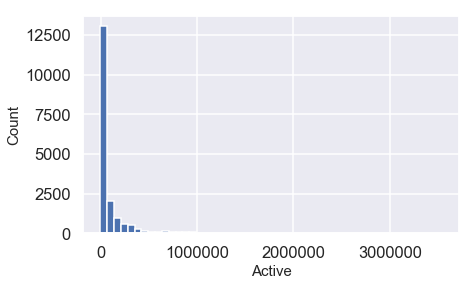

In [25]:
# Quick histogram to check Active distribution
plt.hist(df_daily.active, bins=50)
plt.xlabel('Active', fontsize=15)
plt.ylabel('Count', fontsize=15);

In [26]:
df_daily[df_daily.active < 0]

,state,date,lat,long,confirmed,active,deaths
7979,Northern Mariana Islands,2020-06-04,15.0979,145.6739,24,-8.0,16
8035,Northern Mariana Islands,2020-06-05,15.0979,145.6739,26,-6.0,16
8091,Northern Mariana Islands,2020-06-06,15.0979,145.6739,26,-6.0,16
8147,Northern Mariana Islands,2020-06-07,15.0979,145.6739,26,-7.0,17
8203,Northern Mariana Islands,2020-06-08,15.0979,145.6739,27,-11.0,19
9759,Minnesota,2020-07-06,45.6945,-93.9002,38136,-989.0,1508


In [27]:
# Clearly the negative value is an error
df_daily.loc[(df_daily.state == 'Minnesota') & (df_daily.date > date(2020,7,1))].sort_values('date').head(10)

,state,date,lat,long,confirmed,active,deaths
9535,Minnesota,2020-07-02,45.6945,-93.9002,36716,3287.0,1482
9591,Minnesota,2020-07-03,45.6945,-93.9002,37210,3552.0,1495
9647,Minnesota,2020-07-04,45.6945,-93.9002,37624,3774.0,1503
9703,Minnesota,2020-07-05,45.6945,-93.9002,37624,3774.0,1503
9759,Minnesota,2020-07-06,45.6945,-93.9002,38136,-989.0,1508
9815,Minnesota,2020-07-07,45.6945,-93.9002,38569,3151.0,1511
9871,Minnesota,2020-07-08,45.6945,-93.9002,39133,3242.0,1514
9927,Minnesota,2020-07-09,45.6945,-93.9002,39589,3164.0,1523
9983,Minnesota,2020-07-10,45.6945,-93.9002,40163,3442.0,1528
10039,Minnesota,2020-07-11,45.6945,-93.9002,40767,3792.0,1533


In [28]:
# Two possibilities here: either drop active or replace negative values
#df_daily.drop(columns='active', inplace=True)
df_daily.loc[df_daily.active < 0, 'active'] = np.nan

In [29]:
df_age.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,All Ages,533291.0,4103982.0,460433.0,259678.0,9020.0,741824.0,NaN
1,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,Under 1 year,57.0,22249.0,241.0,8.0,21.0,311.0,NaN
2,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,0-17 years,246.0,38993.0,658.0,44.0,179.0,1039.0,NaN
3,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,1-4 years,31.0,4010.0,136.0,5.0,61.0,223.0,NaN
4,03/31/2021,01/01/2020,03/27/2021,By Total,NaN,NaN,United States,All Sexes,5-14 years,87.0,6479.0,192.0,19.0,76.0,336.0,NaN


In [30]:
df_age.Group.unique()

array(['By Total', 'By Year', 'By Month'], dtype=object)

In [31]:
print(f"df_age.shape: {df_age.shape}")
df_age = df_age.loc[df_age.Group == 'By Month']
print(f"df_age.shape: {df_age.shape}")

df_age.shape: (49572, 16)
df_age.shape: (41310, 16)


In [32]:
df_age.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
8262,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,United States,All Sexes,All Ages,7.0,264612.0,17905.0,5.0,2122.0,20029.0,NaN
8263,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,United States,All Sexes,Under 1 year,0.0,1778.0,41.0,0.0,8.0,49.0,NaN
8264,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,United States,All Sexes,0-17 years,0.0,2958.0,90.0,0.0,63.0,153.0,NaN
8265,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,United States,All Sexes,1-4 years,0.0,315.0,22.0,0.0,18.0,40.0,NaN
8266,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,United States,All Sexes,5-14 years,0.0,470.0,21.0,0.0,29.0,50.0,NaN


In [33]:
df_age.State.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'New York City', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming', 'Puerto Rico'], dtype=object)

In [34]:
df_age = df_age[~df_age.State.isin(['United States', 'New York City'])]

In [35]:
df_age.State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

In [36]:
# Note DC and Puerto Rico are in df_age, but not the other provinces
df_age.State.nunique()

52

In [37]:
df_age.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
9027,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,Alabama,All Sexes,All Ages,0.0,4728.0,282.0,0.0,35.0,317.0,NaN
9028,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,Alabama,All Sexes,Under 1 year,0.0,31.0,0.0,0.0,0.0,0.0,NaN
9029,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,Alabama,All Sexes,0-17 years,0.0,71.0,NaN,0.0,NaN,NaN,One or more data cells have counts between 1-9...
9030,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,Alabama,All Sexes,1-4 years,0.0,12.0,NaN,0.0,0.0,NaN,One or more data cells have counts between 1-9...
9031,03/31/2021,01/01/2020,01/31/2020,By Month,2020.0,1.0,Alabama,All Sexes,5-14 years,0.0,16.0,NaN,0.0,0.0,NaN,One or more data cells have counts between 1-9...


In [38]:
age_cols = ['Year', 'Month', 'State', 'Sex', 'Age Group', 'COVID-19 Deaths', 'Total Deaths']
df_age = df_age[age_cols]

In [39]:
rename = {'Year': 'year', 
          'Month': 'month', 
          'State': 'state', 
          'Sex': 'sex', 
          'Age Group': 'age', 
          'COVID-19 Deaths': 'covid_deaths',
          'Total Deaths': 'total_deaths'}
df_age.rename(columns=rename, inplace=True)

In [40]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39780 entries, 9027 to 49571
Data columns (total 7 columns):
year            39780 non-null float64
month           39780 non-null float64
state           39780 non-null object
sex             39780 non-null object
age             39780 non-null object
covid_deaths    30054 non-null float64
total_deaths    33018 non-null float64
dtypes: float64(4), object(3)
memory usage: 2.4+ MB


In [41]:
df_age.head()

,year,month,state,sex,age,covid_deaths,total_deaths
9027,2020.0,1.0,Alabama,All Sexes,All Ages,0.0,4728.0
9028,2020.0,1.0,Alabama,All Sexes,Under 1 year,0.0,31.0
9029,2020.0,1.0,Alabama,All Sexes,0-17 years,0.0,71.0
9030,2020.0,1.0,Alabama,All Sexes,1-4 years,0.0,12.0
9031,2020.0,1.0,Alabama,All Sexes,5-14 years,0.0,16.0


In [42]:
df_age.sex.unique()

array(['All Sexes', 'Male', 'Female'], dtype=object)

In [43]:
df_age.age.unique()

array(['All Ages', 'Under 1 year', '0-17 years', '1-4 years',
       '5-14 years', '15-24 years', '18-29 years', '25-34 years',
       '30-39 years', '35-44 years', '40-49 years', '45-54 years',
       '50-64 years', '55-64 years', '65-74 years', '75-84 years',
       '85 years and over'], dtype=object)

In [44]:
# Missing values are between 1 and 9 as mentioned in the footnote:
#      One or more data cells have counts between 1-9 and have been suppressed 
#      in accordance with NCHS confidentiality standards.
# Replacing with 5 sounds like a better option than 0 or dropping

In [45]:
df_age.loc[df_age.covid_deaths.isnull(), 'covid_deaths'] = 5
df_age.loc[df_age.total_deaths.isnull(), 'total_deaths'] = 5

In [46]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39780 entries, 9027 to 49571
Data columns (total 7 columns):
year            39780 non-null float64
month           39780 non-null float64
state           39780 non-null object
sex             39780 non-null object
age             39780 non-null object
covid_deaths    39780 non-null float64
total_deaths    39780 non-null float64
dtypes: float64(4), object(3)
memory usage: 2.4+ MB


In [47]:
df_daily.head()

,state,date,lat,long,confirmed,active,deaths
0,Alabama,2021-01-02,32.3182,-86.9023,365747,158738.0,4872
1,Alaska,2021-01-02,61.3707,-152.4044,46986,39615.0,206
2,American Samoa,2021-01-02,-14.2710,-170.1320,0,0.0,0
3,Arizona,2021-01-02,33.7298,-111.4312,530267,444318.0,9015
4,Arkansas,2021-01-02,34.9697,-92.3731,229442,26484.0,3711


In [48]:
df_age.head()

,year,month,state,sex,age,covid_deaths,total_deaths
9027,2020.0,1.0,Alabama,All Sexes,All Ages,0.0,4728.0
9028,2020.0,1.0,Alabama,All Sexes,Under 1 year,0.0,31.0
9029,2020.0,1.0,Alabama,All Sexes,0-17 years,0.0,71.0
9030,2020.0,1.0,Alabama,All Sexes,1-4 years,0.0,12.0
9031,2020.0,1.0,Alabama,All Sexes,5-14 years,0.0,16.0


In [49]:
df_age.age.unique()

array(['All Ages', 'Under 1 year', '0-17 years', '1-4 years',
       '5-14 years', '15-24 years', '18-29 years', '25-34 years',
       '30-39 years', '35-44 years', '40-49 years', '45-54 years',
       '50-64 years', '55-64 years', '65-74 years', '75-84 years',
       '85 years and over'], dtype=object)

In [50]:
# Drop All Ages and All Sexes results to avoid double-counting
df_age = df_age[df_age.age != 'All Ages']
df_age = df_age[df_age.sex != 'All Sexes']

In [51]:
def is_old(age_group):
    if age_group in ['65-74 years', '75-84 years']:
        return True
    return False

df_age['old'] = df_age.age.map(is_old)

## Data Wrangling

All sex and age related categories were appropriately data grouped by state and month. We then grouped the data weekly by state and obtained the sum. We finally dropped all state-weeks which did not have 7 non NaN values. We mapped both datasets making sure that at each week all features were available before the start of the week.

In [52]:
df_female = (df_age[df_age.sex == 'Female']
             .groupby(['year', 'month', 'state'])[['covid_deaths', 'total_deaths']].sum()
             .reset_index())
df_female.head()

,year,month,state,covid_deaths,total_deaths
0,2020.0,1.0,Alabama,0.0,2852.0
1,2020.0,1.0,Alaska,0.0,253.0
2,2020.0,1.0,Arizona,0.0,3197.0
3,2020.0,1.0,Arkansas,0.0,1685.0
4,2020.0,1.0,California,5.0,14478.0


In [53]:
df_male = (df_age[df_age.sex == 'Male']
             .groupby(['year', 'month', 'state'])[['covid_deaths', 'total_deaths']].sum()
             .reset_index())
df_male.head()

,year,month,state,covid_deaths,total_deaths
0,2020.0,1.0,Alabama,0.0,3213.0
1,2020.0,1.0,Alaska,0.0,330.0
2,2020.0,1.0,Arizona,0.0,4114.0
3,2020.0,1.0,Arkansas,0.0,2072.0
4,2020.0,1.0,California,0.0,17698.0


In [54]:
df_old = (df_age[df_age.old]
             .groupby(['year', 'month', 'state'])[['covid_deaths', 'total_deaths']].sum()
             .reset_index())
df_old.head()

,year,month,state,covid_deaths,total_deaths
0,2020.0,1.0,Alabama,0.0,2212.0
1,2020.0,1.0,Alaska,0.0,170.0
2,2020.0,1.0,Arizona,0.0,2683.0
3,2020.0,1.0,Arkansas,0.0,1360.0
4,2020.0,1.0,California,5.0,10661.0


In [55]:
def get_week_year(ds):
    year = ds.date.year
    if (ds.week >= 50) and (ds.date.month == 1):
        return year - 1
    return year


df_daily['week'] = df_daily.date.map(lambda x: x.isocalendar()[1])
df_daily['year'] = df_daily.apply(get_week_year, axis=1)
df_daily = df_daily.sort_values(['state', 'date'])
df_daily['date'] = pd.to_datetime(df_daily.date)

In [56]:
df_daily.head()

,state,date,lat,long,confirmed,active,deaths,week,year
5040,Alabama,2020-04-12,32.3182,-86.9023,3667,3470.0,93,15,2020
5094,Alabama,2020-04-13,32.3182,-86.9023,3870,3635.0,99,16,2020
5149,Alabama,2020-04-14,32.3182,-86.9023,4041,3839.0,114,16,2020
5204,Alabama,2020-04-15,32.3182,-86.9023,4307,3957.0,118,16,2020
5259,Alabama,2020-04-16,32.3182,-86.9023,4465,4212.0,133,16,2020


In [57]:
df_diff = (
    df_daily.set_index(['state', 'date'])
    .groupby(['state'])['confirmed', 'active', 'deaths']
    .diff().reset_index()
)
df_diff.head()

,state,date,confirmed,active,deaths
0,Alabama,2020-04-12,NaN,NaN,NaN
1,Alabama,2020-04-13,203.0,165.0,6.0
2,Alabama,2020-04-14,171.0,204.0,15.0
3,Alabama,2020-04-15,266.0,118.0,4.0
4,Alabama,2020-04-16,158.0,255.0,15.0


In [58]:
df_daily = df_daily.merge(df_diff, left_on=['state', 'date'], right_on=['state', 'date'], suffixes=('_acum', ''))
df_daily.head()

,state,date,lat,long,confirmed_acum,active_acum,deaths_acum,week,year,confirmed,active,deaths
0,Alabama,2020-04-12,32.3182,-86.9023,3667,3470.0,93,15,2020,NaN,NaN,NaN
1,Alabama,2020-04-13,32.3182,-86.9023,3870,3635.0,99,16,2020,203.0,165.0,6.0
2,Alabama,2020-04-14,32.3182,-86.9023,4041,3839.0,114,16,2020,171.0,204.0,15.0
3,Alabama,2020-04-15,32.3182,-86.9023,4307,3957.0,118,16,2020,266.0,118.0,4.0
4,Alabama,2020-04-16,32.3182,-86.9023,4465,4212.0,133,16,2020,158.0,255.0,15.0


In [59]:
df_daily[df_daily.deaths < 0].head()

,state,date,lat,long,confirmed_acum,active_acum,deaths_acum,week,year,confirmed,active,deaths
20,Alabama,2020-05-03,32.3182,-86.9023,7700,7323.0,288,18,2020,260.0,318.0,-1.0
166,Alabama,2020-09-26,32.3182,-86.9023,150239,83584.0,2491,39,2020,976.0,2467.0,-15.0
322,Alabama,2021-03-01,32.3182,-86.9023,493252,198193.0,9929,9,2021,569.0,570.0,-1.0
329,Alabama,2021-03-08,32.3182,-86.9023,499819,NaN,10148,10,2021,408.0,NaN,-1.0
1159,Arizona,2020-07-28,33.7298,-111.4312,163827,139202.0,3304,31,2020,1813.0,1471.0,-1.0


In [60]:
df_daily[df_daily.deaths < 0].shape

(101, 12)

In [61]:
df_daily[df_daily.deaths < 0].deaths.value_counts()

-1.0      43
-2.0      12
-4.0       9
-3.0       7
-13.0      3
-15.0      2
-10.0      2
-9.0       2
-7.0       2
-22.0      2
-5.0       2
-34.0      1
-30.0      1
-17.0      1
-39.0      1
-174.0     1
-27.0      1
-8.0       1
-41.0      1
-68.0      1
-11.0      1
-29.0      1
-6.0       1
-81.0      1
-60.0      1
-90.0      1
Name: deaths, dtype: int64

In [62]:
# Negative deaths will be replaced by 0 (for small negative numbers), or NaN (for bigger negative numbers) 
df_daily.loc[(df_daily.deaths < 0) & (df_daily.deaths >= -5), 'deaths'] = 0
df_daily.loc[df_daily.deaths < -5, 'deaths'] = np.nan

In [63]:
df_daily[df_daily.deaths < 0].shape

(0, 12)

In [64]:
df_daily.shape

(19816, 12)

In [65]:
# The vast majority of missing values are not the ones introduced by us, 
# but the states that were not yet measuring deaths at the start of the pandemic
df_daily.loc[df_daily.deaths.isnull(), 'week'].value_counts()

15    54
52     2
35     2
16     2
18     2
30     2
33     2
9      2
37     1
32     1
31     1
39     1
51     1
27     1
24     1
22     1
40     1
17     1
42     1
45     1
12     1
11     1
10     1
28     1
Name: week, dtype: int64

In [66]:
print(f"df_daily.shape: {df_daily.shape}")
df_daily = df_daily[~df_daily.deaths.isnull()]
print(f"df_daily.shape: {df_daily.shape}")

df_daily.shape: (19816, 12)
df_daily.shape: (19732, 12)


In [67]:
agg_dict = {'lat': min, 'long': min, 'date': [min, max, len], 'confirmed': sum, 'active': sum, 'deaths': sum}
df_week = df_daily.groupby(['state', 'year', 'week']).agg(agg_dict).reset_index()
df_week.columns = ['state', 'year', 'week', 'lat', 'long', 'date_min', 'date_max', 'days', 'confirmed', 'active', 'deaths']
df_week.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,deaths
0,Alabama,2020,16,32.3182,-86.9023,2020-04-13,2020-04-19,7,1311.0,1261.0,64.0
1,Alabama,2020,17,32.3182,-86.9023,2020-04-20,2020-04-26,6,1296.0,1086.0,52.0
2,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,80.0
3,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,102.0
4,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,95.0


In [68]:
print(f'df_week.shape {df_week.shape} (before filtering rows with less than 7 days)')
df_week = df_week.loc[df_week.days == 7]
print(f'df_week.shape {df_week.shape}')

df_week.shape (2855, 11) (before filtering rows with less than 7 days)
df_week.shape (2713, 11)


In [69]:
df_week.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,deaths
0,Alabama,2020,16,32.3182,-86.9023,2020-04-13,2020-04-19,7,1311.0,1261.0,64.0
2,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,80.0
3,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,102.0
4,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,95.0
5,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,64.0


In [70]:
df_week[df_week.deaths < 0].shape[0]

0

In [71]:
df_week['prev_month'] = (df_week.date_min - pd.DateOffset(months=1)).dt.month
df_week['prev_month_year'] = (df_week.date_min - pd.DateOffset(months=1)).dt.year

In [72]:
df_week.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,deaths,prev_month,prev_month_year
0,Alabama,2020,16,32.3182,-86.9023,2020-04-13,2020-04-19,7,1311.0,1261.0,64.0,3,2020
2,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,80.0,3,2020
3,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,102.0,4,2020
4,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,95.0,4,2020
5,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,64.0,4,2020


In [73]:
df_female.head()

,year,month,state,covid_deaths,total_deaths
0,2020.0,1.0,Alabama,0.0,2852.0
1,2020.0,1.0,Alaska,0.0,253.0
2,2020.0,1.0,Arizona,0.0,3197.0
3,2020.0,1.0,Arkansas,0.0,1685.0
4,2020.0,1.0,California,5.0,14478.0


In [74]:
# Merge females
rename = {'month': 'prev_month', 
          'year': 'prev_month_year', 
          'covid_deaths': 'covid_deaths_female_m1',
          'total_deaths': 'total_deaths_female_m1'}

df_week = df_week.merge(df_female.rename(columns=rename), 
              left_on=['state', 'prev_month_year', 'prev_month'], 
              right_on=['state', 'prev_month_year', 'prev_month'])

In [75]:
# Merge males
rename = {'month': 'prev_month', 
          'year': 'prev_month_year', 
          'covid_deaths': 'covid_deaths_male_m1',
          'total_deaths': 'total_deaths_male_m1'}

df_week = df_week.merge(df_male.rename(columns=rename), 
              left_on=['state', 'prev_month_year', 'prev_month'], 
              right_on=['state', 'prev_month_year', 'prev_month'])

In [76]:
# Merge old
rename = {'month': 'prev_month', 
          'year': 'prev_month_year', 
          'covid_deaths': 'covid_deaths_old_m1',
          'total_deaths': 'total_deaths_old_m1'}

df_week = df_week.merge(df_old.rename(columns=rename), 
              left_on=['state', 'prev_month_year', 'prev_month'], 
              right_on=['state', 'prev_month_year', 'prev_month'])

In [77]:
df_week.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,deaths,prev_month,prev_month_year,covid_deaths_female_m1,total_deaths_female_m1,covid_deaths_male_m1,total_deaths_male_m1,covid_deaths_old_m1,total_deaths_old_m1
0,Alabama,2020,16,32.3182,-86.9023,2020-04-13,2020-04-19,7,1311.0,1261.0,64.0,3,2020,35.0,2818.0,50.0,3328.0,20.0,2216.0
1,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,80.0,3,2020,35.0,2818.0,50.0,3328.0,20.0,2216.0
2,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,102.0,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0
3,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,95.0,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0
4,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,64.0,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0


For the deaths data in New Jersey, we observed an anomalous spike on week 26, as shown below. This spike is possibly due to the adjustment in the death tolls in the early period of the pandemic and we decided to correct it. We replaced it with the average between the deaths on week 25 and 27.

In [78]:
df_anomaly = df_week.loc[(df_week.state == 'New Jersey') & (df_week.week.isin(range(20, 35)))]

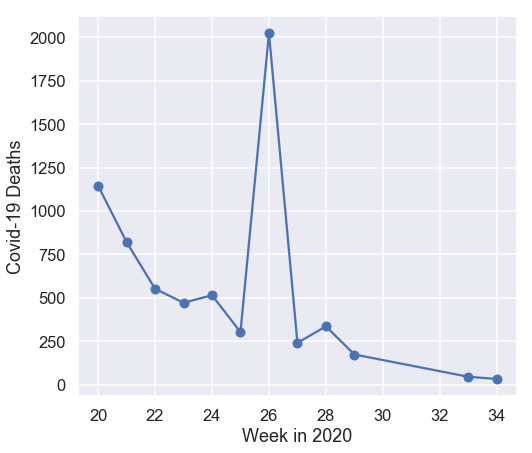

In [79]:
plt.figure(figsize=(7, 7))
plt.plot(df_anomaly.week, df_anomaly.deaths, marker='o')
if include_plot_title:
    plt.title('Deaths in New Jersey in Period of Anomaly')
plt.xlabel('Week in 2020')
plt.ylabel('Covid-19 Deaths')
plt.savefig(f'{image_folder}nj_anomaly.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');

In [80]:
deaths_25 = df_week.loc[(df_week.state == 'New Jersey') & (df_week.week == 25), 'deaths'].iloc[0]
deaths_27 = df_week.loc[(df_week.state == 'New Jersey') & (df_week.week == 27), 'deaths'].iloc[0]

In [81]:
df_week.loc[(df_week.state == 'New Jersey') & (df_week.week == 26), 'deaths'] = (deaths_25 + deaths_27)/2

In [82]:
df_week.loc[(df_week.state == 'New Jersey') & (df_week.week.isin(range(24, 30))), 
            ['state', 'year', 'week', 'deaths']]

,state,year,week,deaths
1459,New Jersey,2020,24,515.0
1460,New Jersey,2020,25,303.0
1461,New Jersey,2020,26,272.0
1462,New Jersey,2020,27,241.0
1463,New Jersey,2020,28,336.0
1464,New Jersey,2020,29,174.0


## Feature Engineering

In order to make forecasts, we make use of the correlations between the past and the future. One way to incorporate the past is to use the statistics from a few weeks ago as our regressors and regress the future week’s statistics on these regressors. We therefore chose the cases/deaths four weeks ago, three weeks ago, two weeks ago, and one week ago, respectively denoted as confirmed/deaths\_w1, confirmed/deaths\_w2, confirmed/deaths\_w3, confirmed/deaths\_w4 as some of our features. We also included the total deaths and deaths caused by COVID-19 in the past month (m1) as well as the month before the past month (m2), on male, female and old, denoted as total/covid\_deaths\_male\_m1/m2, total/covid\_deaths\_female\_m1/m2, total/covid\_deaths\_old\_m1/m2.

### Same state data

In [83]:
weeks = (df_week[['year', 'week']]
         .drop_duplicates().reset_index()
         .rename(columns={'index': 'week_index'}))
weeks = weeks.loc[weeks.week_index > 0]
weeks

,week_index,year,week
1,1,2020,18
2,2,2020,19
3,3,2020,20
4,4,2020,21
5,5,2020,22
6,6,2020,23
7,7,2020,24
8,8,2020,25
9,9,2020,26
10,10,2020,27


In [84]:
df_feat = df_week.merge(weeks, 
                        left_on=['year', 'week'], 
                        right_on=['year', 'week'])
df_feat = df_feat.sort_values(['state', 'week_index'])
df_feat['prev_month_index'] = 12*(df_feat.prev_month_year-2020) + df_feat.prev_month
df_feat.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,...,prev_month,prev_month_year,covid_deaths_female_m1,total_deaths_female_m1,covid_deaths_male_m1,total_deaths_male_m1,covid_deaths_old_m1,total_deaths_old_m1,week_index,prev_month_index
0,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,...,3,2020,35.0,2818.0,50.0,3328.0,20.0,2216.0,1,3
50,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,...,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0,2,4
102,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,...,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0,3,4
154,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,...,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0,4,4
206,Alabama,2020,22,32.3182,-86.9023,2020-05-25,2020-05-31,7,3361.0,1769.0,...,4,2020,187.0,2849.0,247.0,3447.0,179.0,2285.0,5,4


In [85]:
def add_previous_data(df, column, n_weeks, index_prefix='week'):
    """
    Input:
        df -> df_feat
        column thought to be deaths, confirmed, total_deaths_female, etc
    """
    index_name = f'{index_prefix}_index'
    for i in range(1, n_weeks+1):
        index_name_prev = f'week_index_w{i}'
        df[index_name_prev] = df[index_name] - i
        df = df.merge(df[['state', index_name, column]]
                                .set_index(['state', index_name]), 
                      how='left', 
                      left_on=['state', index_name_prev], 
                      right_index=True, 
                      suffixes=('', f'_w{i}'))
        df.drop(columns=index_name_prev, inplace=True)
    return df

In [86]:
print(f'df_feat.shape {df_feat.shape} before')
df_feat = add_previous_data(df_feat, 'deaths', 4, 'week')
df_feat = add_previous_data(df_feat, 'confirmed', 4, 'week')
print(f'df_feat.shape {df_feat.shape} after')

df_feat.shape (2470, 21) before
df_feat.shape (2470, 29) after


In [87]:
df_months = df_feat[['state', 'prev_month_index', 'covid_deaths_female_m1', 'covid_deaths_male_m1', 'covid_deaths_old_m1']] \
            .drop_duplicates()

In [88]:
def add_previous_monthly_data(df, column, n_weeks):
    index_name = 'prev_month_index'
    for i in range(1, n_weeks + 1):
        index_name_prev = f'prev_month_index_m{i+1}'
        df[index_name_prev] = df[index_name] - i
        df = df.merge(df_months[['state', index_name, column]]
                            .set_index(['state', index_name]), 
                  how='left', 
                  left_on=['state', index_name_prev], 
                  right_index=True, 
                  suffixes=('', 'x'))
        rename = {f'{column}x': f"{column[:-3]}_m{i+1}"}
        print(rename)
        df.rename(columns=rename, inplace=True)
        df.drop(columns=index_name_prev, inplace=True)
    return df

In [89]:
df_feat.columns

Index(['state', 'year', 'week', 'lat', 'long', 'date_min', 'date_max', 'days',
       'confirmed', 'active', 'deaths', 'prev_month', 'prev_month_year',
       'covid_deaths_female_m1', 'total_deaths_female_m1',
       'covid_deaths_male_m1', 'total_deaths_male_m1', 'covid_deaths_old_m1',
       'total_deaths_old_m1', 'week_index', 'prev_month_index', 'deaths_w1',
       'deaths_w2', 'deaths_w3', 'deaths_w4', 'confirmed_w1', 'confirmed_w2',
       'confirmed_w3', 'confirmed_w4'],
      dtype='object')

In [90]:
print(f'df_feat.shape {df_feat.shape} before')
df_feat = add_previous_monthly_data(df_feat, 'covid_deaths_female_m1', 1)
df_feat = add_previous_monthly_data(df_feat, 'covid_deaths_male_m1', 1)
df_feat = add_previous_monthly_data(df_feat, 'covid_deaths_old_m1', 1)
print(f'df_feat.shape {df_feat.shape} after')

df_feat.shape (2470, 29) before
{'covid_deaths_female_m1x': 'covid_deaths_female_m2'}
{'covid_deaths_male_m1x': 'covid_deaths_male_m2'}
{'covid_deaths_old_m1x': 'covid_deaths_old_m2'}
df_feat.shape (2470, 32) after


In [91]:
df_feat.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,...,deaths_w2,deaths_w3,deaths_w4,confirmed_w1,confirmed_w2,confirmed_w3,confirmed_w4,covid_deaths_female_m2,covid_deaths_male_m2,covid_deaths_old_m2
0,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,...,NaN,NaN,NaN,1426.0,NaN,NaN,NaN,35.0,50.0,20.0
102,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,...,80.0,NaN,NaN,2020.0,1426.0,NaN,NaN,35.0,50.0,20.0
154,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,...,102.0,80.0,NaN,2108.0,2020.0,1426.0,NaN,35.0,50.0,20.0
206,Alabama,2020,22,32.3182,-86.9023,2020-05-25,2020-05-31,7,3361.0,1769.0,...,95.0,102.0,80.0,2500.0,2108.0,2020.0,1426.0,35.0,50.0,20.0


In [92]:
df_feat.columns

Index(['state', 'year', 'week', 'lat', 'long', 'date_min', 'date_max', 'days',
       'confirmed', 'active', 'deaths', 'prev_month', 'prev_month_year',
       'covid_deaths_female_m1', 'total_deaths_female_m1',
       'covid_deaths_male_m1', 'total_deaths_male_m1', 'covid_deaths_old_m1',
       'total_deaths_old_m1', 'week_index', 'prev_month_index', 'deaths_w1',
       'deaths_w2', 'deaths_w3', 'deaths_w4', 'confirmed_w1', 'confirmed_w2',
       'confirmed_w3', 'confirmed_w4', 'covid_deaths_female_m2',
       'covid_deaths_male_m2', 'covid_deaths_old_m2'],
      dtype='object')

### Influential states

We think that geographic locations can play a role in the forecast of deaths. In particular, there may be correlations between the deaths in a state in the near future and the statistics in the states that are close by. We extract the influential states to any given state using two methods -- using the vector autoregression (VAR) model and using the proximity method, denoted with suffices \_influential\_var and \_influential\_prox, respectively.

The VAR model consists of 52 separate regressions wrapped in one convenient algorithm. Each regression will use the deaths of one particular state and regress it against the deaths of all states separately with a lag. We are using daily data here because in this case there would be linear dependence if using weekly as there would be 36 rows (weeks in the training data) and 52 features (number of states), whereas when using daily training data we have 277 rows for each regression and the same 52 features. We say a state X is influential for another state Y if the coefficient of the state X’s lagged deaths is significant in forecasting the deaths of Y (we are using a significance of $5\%$ for the p-values). Afterward, we filter only positive coefficients, because we do not believe in a causal relationship where a state’s deaths decrease because the deaths in another state increased one day before. To this point we were able to determine a list of influential states for each state.

Finally, we process the features by scaling the deaths of all the influential states (var or prox, separately) using the deaths pre-COVID. The reason we do this is that we want the feature to be of the right order of magnitude, and not obtain a lower estimate for states that have less populated states as influential states. To be precise, let $X_1, \dots, X_k$ be the VAR or proximity based states list of a state Y. We computed a ratio for each of the states $X_i$ on the list defined as the average deaths pre-covid of state Y divided by the deaths pre-covid of state $X_i$. Then, when multiplying a particular feature of an influential state (e.g. deaths\_w1) by the the ratio, then the resulting feature will be of a similar order of magnitude as in state Y. After scaling the feature for all neighboring states, we compute the simple average, and that is our final feature for state Y. The same scaling and averaging methodology was used for proximity-based states. We initially computed this feature for deaths\_w1 using for both VAR and proximity based states, and called the features deaths\_w1\_influential\_var and deaths\_w1\_influential\_prox, respectively. Then, after noticing that the influential\_var feature was useful we came back and added a VAR-based states feature using confirmed\_w2, which is naturally called confirmed\_w2\_influential\_var.

In [93]:
states = list(df_feat.state.unique())

#### VAR (based on linear regression of lagged states deaths)

In [94]:
date_test_start = df_feat[df_feat.week_index == 41].date_min.unique()[0]
date_test_start

numpy.datetime64('2021-02-08T00:00:00.000000000')

In [95]:
df_daily_pivot = (df_daily
                  .loc[df_daily.date < date_test_start]
                  .pivot_table(index='date', columns='state', values='deaths')[states].dropna()
)
df_daily_pivot.tail()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2021-02-03,206.0,17.0,238.0,44.0,500.0,9.0,14.0,8.0,0.0,137.0,...,1.0,147.0,374.0,17.0,1.0,43.0,0.0,3.0,44.0,28.0
2021-02-04,309.0,0.0,214.0,46.0,582.0,14.0,24.0,2.0,10.0,197.0,...,3.0,133.0,420.0,12.0,3.0,58.0,72.0,27.0,16.0,0.0
2021-02-05,162.0,0.0,176.0,24.0,636.0,18.0,28.0,3.0,6.0,228.0,...,6.0,169.0,414.0,14.0,2.0,75.0,28.0,22.0,49.0,0.0
2021-02-06,84.0,0.0,196.0,41.0,570.0,23.0,29.0,4.0,8.0,210.0,...,10.0,203.0,440.0,17.0,0.0,82.0,33.0,20.0,30.0,0.0
2021-02-07,64.0,0.0,63.0,11.0,301.0,17.0,0.0,4.0,7.0,142.0,...,6.0,58.0,289.0,5.0,1.0,41.0,0.0,19.0,36.0,0.0


In [96]:
df_daily_pivot.shape

(277, 52)

In [97]:
model_var = VAR(df_daily_pivot)
res_var = model_var.fit(1)

In [98]:
#res_var.summary()

In [99]:
pvalues_var = res_var.pvalues.round(2)
pvalues_var

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
const,0.39,0.75,0.00,0.00,0.00,0.92,0.16,0.24,0.73,0.00,...,0.70,0.06,0.00,0.00,0.07,0.01,0.00,0.51,0.08,0.16
L1.Alabama,0.01,0.17,0.04,0.44,0.05,0.94,0.49,0.85,0.07,0.14,...,0.40,0.01,0.28,0.50,0.67,0.00,0.75,0.57,0.10,0.32
L1.Alaska,0.63,0.19,0.08,0.54,0.45,0.49,0.05,0.43,0.13,0.18,...,0.04,0.54,0.29,0.01,0.46,0.27,0.15,0.33,0.74,0.17
L1.Arizona,0.08,0.00,0.10,0.22,0.17,0.36,0.27,0.44,0.60,0.84,...,0.43,0.23,0.47,0.23,0.15,0.12,0.98,0.07,0.01,0.01
L1.Arkansas,0.62,0.79,0.62,0.16,0.17,0.86,0.95,0.80,0.95,0.53,...,0.06,0.17,0.84,0.46,0.34,0.26,0.74,0.02,0.39,0.36
L1.California,0.00,0.01,0.00,0.45,0.00,0.94,0.05,0.76,0.37,0.86,...,0.16,0.00,0.02,0.00,0.62,0.00,0.10,0.01,0.37,0.18
L1.Colorado,0.49,0.05,0.79,0.64,0.80,0.15,0.14,0.29,0.61,0.36,...,0.34,0.07,0.75,0.85,0.00,0.71,0.35,0.08,0.09,0.41
L1.Connecticut,0.02,0.10,0.04,0.60,0.11,0.51,0.99,0.17,0.19,0.30,...,0.95,0.89,0.79,0.06,0.10,0.02,0.00,0.17,0.19,0.20
L1.Delaware,0.84,0.45,0.63,0.29,0.04,0.26,0.00,0.00,0.00,0.27,...,0.58,0.14,0.50,0.36,0.03,0.83,0.13,0.42,0.82,0.76
L1.District of Columbia,0.51,0.66,0.12,0.36,0.80,0.49,0.21,0.05,0.17,0.89,...,0.56,0.11,0.97,0.13,0.84,0.60,0.03,0.22,0.06,0.37


In [100]:
params_var = res_var.params.round(2)
params_var

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
const,4.24,-0.13,27.72,8.73,50.75,-0.32,-4.71,0.55,0.13,55.39,...,-0.49,8.39,44.82,2.21,-0.28,6.89,10.92,0.63,5.57,1.42
L1.Alabama,0.19,-0.01,0.19,-0.03,0.37,0.00,0.03,-0.00,0.01,0.17,...,0.02,0.16,0.23,0.01,-0.00,0.10,0.01,0.01,0.08,-0.01
L1.Alaska,0.43,0.09,2.07,-0.28,-1.78,-0.42,-1.21,0.07,-0.11,-1.95,...,-0.47,0.50,2.81,0.34,0.02,0.50,0.69,-0.17,0.19,-0.25
L1.Arizona,-0.10,-0.01,-0.13,-0.04,-0.21,-0.04,0.04,-0.00,-0.00,0.02,...,-0.01,-0.06,-0.12,0.01,0.00,-0.04,-0.00,-0.02,-0.09,-0.03
L1.Arkansas,-0.07,0.00,-0.10,0.10,0.53,-0.02,-0.01,0.00,-0.00,0.15,...,-0.07,0.18,0.09,0.02,0.00,0.08,0.03,0.07,0.08,0.03
L1.California,0.17,0.01,0.30,0.01,0.55,0.00,-0.04,0.00,-0.00,-0.01,...,-0.01,0.10,0.22,0.02,0.00,0.05,0.03,0.02,0.02,0.01
L1.Colorado,0.07,0.02,-0.04,-0.02,0.07,0.10,0.10,-0.01,0.00,0.15,...,0.02,0.16,-0.09,-0.00,0.01,0.02,-0.05,-0.03,-0.11,-0.02
L1.Connecticut,0.21,-0.01,0.25,-0.02,0.37,0.04,0.00,-0.01,0.01,0.15,...,-0.00,0.01,-0.07,0.03,0.00,0.10,0.18,0.02,0.08,0.02
L1.Delaware,-0.15,-0.04,0.47,0.38,3.99,0.56,1.58,0.26,0.18,1.31,...,-0.10,0.97,1.46,0.10,-0.05,0.08,0.58,-0.11,0.10,0.04
L1.District of Columbia,0.53,-0.03,-1.69,-0.37,-0.54,-0.38,0.69,0.15,0.08,-0.19,...,0.12,-1.16,0.09,-0.19,-0.00,-0.21,-0.94,-0.19,-0.98,-0.15


In [101]:
def get_influential_states_var_based(state, remove_same_state=False):
    pvals_state = pvalues_var[state]
    pvals_state = pvals_state[pvals_state < 0.05]
    if remove_same_state:
        pvals_state = pvals_state[~pvals_state.index.isin(['const', f'L1.{state}'])]
    else:
        pvals_state = pvals_state[~pvals_state.index.isin(['const'])]
    influential_states = list(pvals_state.index)
    params_state = params_var[state]
    params_state = params_state.loc[influential_states]
    params_state = params_state[params_state > 0]
    influential_states = [e.replace('L1.', '') for e in params_state.index]    
    
    return influential_states

In [102]:
influential_states_var = {state: get_influential_states_var_based(state) for state in states}
df_influential_states_var = pd.DataFrame({state: [neigh] for state, neigh in influential_states_var.items()}, 
                                         index=['influential_states']).T
with pd.option_context('display.max_colwidth', 400):
    display(df_influential_states_var)

,influential_states
Alabama,"[Alabama, California, Connecticut, Maine, Missouri, South Carolina, Tennessee, Washington, Wyoming]"
Alaska,"[California, Idaho, Iowa, Kansas, South Carolina, Wyoming]"
Arizona,"[Alabama, California, Connecticut, Nevada, Vermont]"
Arkansas,"[Ohio, Tennessee]"
California,"[California, Delaware, Kentucky, Louisiana, Nevada, Tennessee, Vermont]"
Colorado,"[Idaho, Illinois, Louisiana, Montana, Nebraska, Utah]"
Connecticut,"[Delaware, Louisiana, Massachusetts, Mississippi, New York, Ohio, Pennsylvania]"
Delaware,"[Delaware, Michigan, Rhode Island]"
District of Columbia,"[Delaware, Maryland, Massachusetts]"
Florida,"[Florida, Mississippi, Texas]"


In [103]:
state_acronym_map = {
    'Alabama': 'AL',
    'Montana': 'MT',
    'Alaska': 'AK',
    'Nebraska': 'NE',
    'Arizona': 'AZ',
    'Nevada': 'NV',
    'Arkansas': 'AR',
    'New Hampshire': 'NH',
    'California': 'CA',
    'New Jersey': 'NJ',
    'Colorado': 'CO',
    'New Mexico': 'NM',
    'Connecticut': 'CT',
    'New York': 'NY',
    'Delaware': 'DE',
    'North Carolina': 'NC',
    'Florida': 'FL',
    'North Dakota': 'ND',
    'Georgia': 'GA',
    'Ohio': 'OH',
    'Hawaii': 'HI',
    'Oklahoma': 'OK',
    'Idaho': 'ID',
    'Oregon': 'OR',
    'Illinois': 'IL',
    'Pennsylvania': 'PA',
    'Indiana': 'IN',
    'Rhode Island': 'RI',
    'Iowa': 'IA',
    'South Carolina': 'SC',
    'Kansas': 'KS',
    'South Dakota': 'SD',
    'Kentucky': 'KY',
    'Tennessee': 'TN',
    'Louisiana': 'LA',
    'Texas': 'TX',
    'Maine': 'ME',
    'Utah': 'UT',
    'Maryland': 'MD',
    'Vermont': 'VT',
    'Massachusetts': 'MA',
    'Virginia': 'VA',
    'Michigan': 'MI',
    'Washington': 'WA',
    'Minnesota': 'MN',
    'West Virginia': 'WV',
    'Mississippi': 'MS',
    'Wisconsin': 'WI',
    'Missouri': 'MO',
    'Wyoming': 'WY',
    'District of Columbia': 'DC', 
    'Puerto Rico': 'PR',
}

In [104]:
df_influential_states_var_latex = df_influential_states_var.copy()
df_influential_states_var_latex.index = df_influential_states_var_latex.index.map(state_acronym_map)
def abbreviate_state_list(state_list):
    return ', '.join([state_acronym_map[state] for state in state_list])

df_influential_states_var_latex['influential_states'] = \
    df_influential_states_var_latex.influential_states.map(abbreviate_state_list)

In [105]:
# Table used on the report
print(df_influential_states_var_latex.to_latex())

\begin{tabular}{ll}
\toprule
{} &                  influential\_states \\
\midrule
AL &  AL, CA, CT, ME, MO, SC, TN, WA, WY \\
AK &              CA, ID, IA, KS, SC, WY \\
AZ &                  AL, CA, CT, NV, VT \\
AR &                              OH, TN \\
CA &          CA, DE, KY, LA, NV, TN, VT \\
CO &              ID, IL, LA, MT, NE, UT \\
CT &          DE, LA, MA, MS, NY, OH, PA \\
DE &                          DE, MI, RI \\
DC &                          DE, MD, MA \\
FL &                          FL, MS, TX \\
GA &                          AL, KS, KY \\
HI &                      KY, NE, SD, TN \\
ID &                      HI, NE, OK, VT \\
IL &                  IN, KS, NE, PA, RI \\
IN &              AL, IN, MT, ND, OH, WA \\
IA &                      CO, NV, RI, VA \\
KS &  AZ, CA, CO, ID, IN, LA, MO, NE, VT \\
KY &              AL, IN, KS, OH, OK, WI \\
LA &                      CT, SC, TX, WI \\
ME &          CA, ID, KS, ME, SC, UT, WV \\
MD &                      DC, MA, NE,

#### Based on proximity

In [106]:
state_coords = df_feat[['state', 'lat', 'long']].drop_duplicates()
state_coords.head()

,state,lat,long
0,Alabama,32.3182,-86.9023
1,Alaska,61.3707,-152.4044
2,Arizona,33.7298,-111.4312
3,Arkansas,34.9697,-92.3731
4,California,36.1162,-119.6816


In [107]:
def get_influential_states_proximity_based(state):
    coord = state_coords.loc[state_coords.state == state]
    lat = coord.lat.iloc[0]
    long = coord.long.iloc[0]
    sq_dist = state_coords.apply(lambda row: (row.lat - lat)**2 + (row.long - long)**2, axis=1)
    neigh_states_ix = sq_dist[sq_dist > 0].sort_values().iloc[:3].index
    neigh_states = state_coords.loc[neigh_states_ix].state.to_list()
    return neigh_states

In [108]:
influential_states_prox = {state: get_influential_states_proximity_based(state) for state in states}
df_influential_states_prox = pd.DataFrame({state: [neigh] for state, neigh in influential_states_prox.items()}, 
                                         index=['influential_states']).T
with pd.option_context('display.max_colwidth', 400):
    display(df_influential_states_prox)

,influential_states
Alabama,"[Mississippi, Georgia, Tennessee]"
Alaska,"[Washington, Oregon, Hawaii]"
Arizona,"[New Mexico, Utah, Nevada]"
Arkansas,"[Missouri, Mississippi, Louisiana]"
California,"[Nevada, Arizona, Oregon]"
Colorado,"[Wyoming, New Mexico, Utah]"
Connecticut,"[Rhode Island, Massachusetts, New Jersey]"
Delaware,"[Maryland, New Jersey, District of Columbia]"
District of Columbia,"[Maryland, Delaware, Virginia]"
Florida,"[Georgia, South Carolina, Alabama]"


In [109]:
df_influential_states_prox_latex = df_influential_states_prox.copy()
df_influential_states_prox_latex.index = df_influential_states_prox_latex.index.map(state_acronym_map)

df_influential_states_prox_latex['influential_states'] = \
    df_influential_states_prox_latex.influential_states.map(abbreviate_state_list)

In [110]:
print(df_influential_states_prox_latex.to_latex())

\begin{tabular}{ll}
\toprule
{} & influential\_states \\
\midrule
AL &         MS, GA, TN \\
AK &         WA, OR, HI \\
AZ &         NM, UT, NV \\
AR &         MO, MS, LA \\
CA &         NV, AZ, OR \\
CO &         WY, NM, UT \\
CT &         RI, MA, NJ \\
DE &         MD, NJ, DC \\
DC &         MD, DE, VA \\
FL &         GA, SC, AL \\
GA &         SC, AL, TN \\
HI &         AK, CA, OR \\
ID &         MT, UT, NV \\
IL &         IN, MO, WI \\
IN &         KY, IL, OH \\
IA &         MO, MN, WI \\
KS &         OK, NE, MO \\
KY &         IN, TN, OH \\
LA &         MS, AR, AL \\
ME &         NH, MA, VT \\
MD &         DC, DE, PA \\
MA &         RI, NH, CT \\
MI &         OH, IN, WI \\
MN &         IA, WI, SD \\
MS &         LA, AL, AR \\
MO &         AR, IA, IL \\
MT &         ID, WY, UT \\
NE &         KS, SD, IA \\
NV &         CA, UT, ID \\
NH &         MA, VT, RI \\
NJ &         DE, NY, CT \\
NM &         CO, AZ, UT \\
NY &         NJ, CT, PA \\
NC &         SC, VA, WV \\
ND &         SD,

#### Create influential states features

In [111]:
# Get pre-covid deaths average for each state
# This will be later used to scale the cases of neighboring states
df_all = df_female.merge(df_male, left_on=['year', 'month', 'state'], 
                         right_on=['year', 'month', 'state'], 
                         suffixes=('_female', '_male'))
df_all['total_deaths'] = df_all['total_deaths_female'] + df_all['total_deaths_male']
state_deaths_precovid = (
    df_all
     .loc[(df_all.year == 2020) & (df_all.month <= 3) & (df_all.state.isin(states))]
     .groupby('state')['total_deaths']
     .sum()
)
state_deaths_precovid.head()

state
Alabama       18226.0
Alaska         1586.0
Arizona       21609.0
Arkansas      10968.0
California    93352.0
Name: total_deaths, dtype: float64

In [112]:
column = 'deaths_w1'
name = 'var'
new_feature_name = f"{column}_influential_{name}"
influential_states_dict = influential_states_var

In [113]:
def add_influential_states(df_feat, column, name, influential_states_dict):
    new_feature_name = f"{column}_influential_{name}"
    df_new = pd.DataFrame(columns=['state', 'week_index', new_feature_name])
    for state in states:
        print(state, end = ' ')
        deaths_precovid_state = state_deaths_precovid.loc[state_deaths_precovid.index == state].iloc[0]
        df_state = df_feat[df_feat.state == state]
        influential_states = influential_states_dict[state]
        for influential_state in influential_states:
            df_influential_state = df_feat[df_feat.state == influential_state]
            df_influential_state = df_influential_state[['state', 'year', 'week', 'week_index', column]]
            deaths_precovid_influential_state = state_deaths_precovid.loc[state_deaths_precovid.index == influential_state].iloc[0]
            ratio = deaths_precovid_state / deaths_precovid_influential_state
            df_influential_state[column] = df_influential_state[column] * ratio
            new_column = f"{column}_{influential_state}"
            df_influential_state.rename(columns={column: new_column}, inplace=True)
            df_state = df_state.merge(df_influential_state[['week_index', new_column]], 
                                      left_on=['week_index'], 
                                      right_on=['week_index'])
        cols = [f"{column}_{influential_state}" for influential_state in influential_states]
        df_state[new_feature_name] = df_state[cols].mean(axis=1, skipna=True)
        df_new = pd.concat((df_new, df_state[['state', 'week_index', new_feature_name]]))

    df_feat = df_feat.merge(df_new, how='left',
                            left_on=['state', 'week_index'], 
                            right_on=['state', 'week_index'])
    return df_feat

In [114]:
df_feat = add_influential_states(df_feat, 'deaths_w1', 'var', influential_states_var)

Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware District of Columbia Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New Hampshire New Jersey New Mexico New York North Carolina North Dakota Ohio Oklahoma Oregon Pennsylvania Puerto Rico Rhode Island South Carolina South Dakota Tennessee Texas Utah Vermont Virginia Washington West Virginia Wisconsin Wyoming 

In [115]:
df_feat = add_influential_states(df_feat, 'deaths_w1', 'prox', influential_states_prox)

Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware District of Columbia Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New Hampshire New Jersey New Mexico New York North Carolina North Dakota Ohio Oklahoma Oregon Pennsylvania Puerto Rico Rhode Island South Carolina South Dakota Tennessee Texas Utah Vermont Virginia Washington West Virginia Wisconsin Wyoming 

In [116]:
df_feat = add_influential_states(df_feat, 'confirmed_w2', 'var', influential_states_var)

Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware District of Columbia Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New Hampshire New Jersey New Mexico New York North Carolina North Dakota Ohio Oklahoma Oregon Pennsylvania Puerto Rico Rhode Island South Carolina South Dakota Tennessee Texas Utah Vermont Virginia Washington West Virginia Wisconsin Wyoming 

In [117]:
df_feat.head()

,state,year,week,lat,long,date_min,date_max,days,confirmed,active,...,confirmed_w1,confirmed_w2,confirmed_w3,confirmed_w4,covid_deaths_female_m2,covid_deaths_male_m2,covid_deaths_old_m2,deaths_w1_influential_var,deaths_w1_influential_prox,confirmed_w2_influential_var
0,Alabama,2020,18,32.3182,-86.9023,2020-04-27,2020-05-03,7,1426.0,1506.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2020,19,32.3182,-86.9023,2020-05-04,2020-05-10,7,2020.0,1955.0,...,1426.0,NaN,NaN,NaN,35.0,50.0,20.0,177.970532,100.088747,NaN
2,Alabama,2020,20,32.3182,-86.9023,2020-05-11,2020-05-17,7,2108.0,1911.0,...,2020.0,1426.0,NaN,NaN,35.0,50.0,20.0,153.426826,124.956456,2355.239924
3,Alabama,2020,21,32.3182,-86.9023,2020-05-18,2020-05-24,7,2500.0,-5572.0,...,2108.0,2020.0,1426.0,NaN,35.0,50.0,20.0,131.052174,100.429524,2026.022552
4,Alabama,2020,22,32.3182,-86.9023,2020-05-25,2020-05-31,7,3361.0,1769.0,...,2500.0,2108.0,2020.0,1426.0,35.0,50.0,20.0,114.913786,111.273440,2025.682054


### Final features DataFrame

In [118]:
df_final = df_feat[['state', 'year', 'week', 'week_index', 'lat', 'long',
                    'deaths_w1', 'deaths_w2', 'deaths_w3', 'deaths_w4', 
                    'confirmed_w1', 'confirmed_w2', 'confirmed_w3', 'confirmed_w4', 
                    'covid_deaths_female_m1', 'total_deaths_female_m1', 'covid_deaths_female_m2',
                    'covid_deaths_male_m1','total_deaths_male_m1', 'covid_deaths_male_m2',
                    'covid_deaths_old_m1', 'total_deaths_old_m1', 'covid_deaths_old_m2', 
                    'deaths_w1_influential_var', 'deaths_w1_influential_prox',
                    'confirmed_w2_influential_var', 'deaths']]

In [119]:
df_final.head()

,state,year,week,week_index,lat,long,deaths_w1,deaths_w2,deaths_w3,deaths_w4,...,covid_deaths_male_m1,total_deaths_male_m1,covid_deaths_male_m2,covid_deaths_old_m1,total_deaths_old_m1,covid_deaths_old_m2,deaths_w1_influential_var,deaths_w1_influential_prox,confirmed_w2_influential_var,deaths
0,Alabama,2020,18,1,32.3182,-86.9023,NaN,NaN,NaN,NaN,...,50.0,3328.0,NaN,20.0,2216.0,NaN,NaN,NaN,NaN,80.0
1,Alabama,2020,19,2,32.3182,-86.9023,80.0,NaN,NaN,NaN,...,247.0,3447.0,50.0,179.0,2285.0,20.0,177.970532,100.088747,NaN,102.0
2,Alabama,2020,20,3,32.3182,-86.9023,102.0,80.0,NaN,NaN,...,247.0,3447.0,50.0,179.0,2285.0,20.0,153.426826,124.956456,2355.239924,95.0
3,Alabama,2020,21,4,32.3182,-86.9023,95.0,102.0,80.0,NaN,...,247.0,3447.0,50.0,179.0,2285.0,20.0,131.052174,100.429524,2026.022552,64.0
4,Alabama,2020,22,5,32.3182,-86.9023,64.0,95.0,102.0,80.0,...,247.0,3447.0,50.0,179.0,2285.0,20.0,114.913786,111.273440,2025.682054,69.0


## EDA

We comment on the following EDA graphs at length in the report. A summary is the following: 
- Many features are highly correlated. We should continue with caution.
- All m1 features are extremely highly correlated. Only one should be chosen (we chose old).
- m2 features are largely uninformative.
- There seem to be clusters of states based on the correlation matrix of states deaths. More evidence for using the VAR-based features.

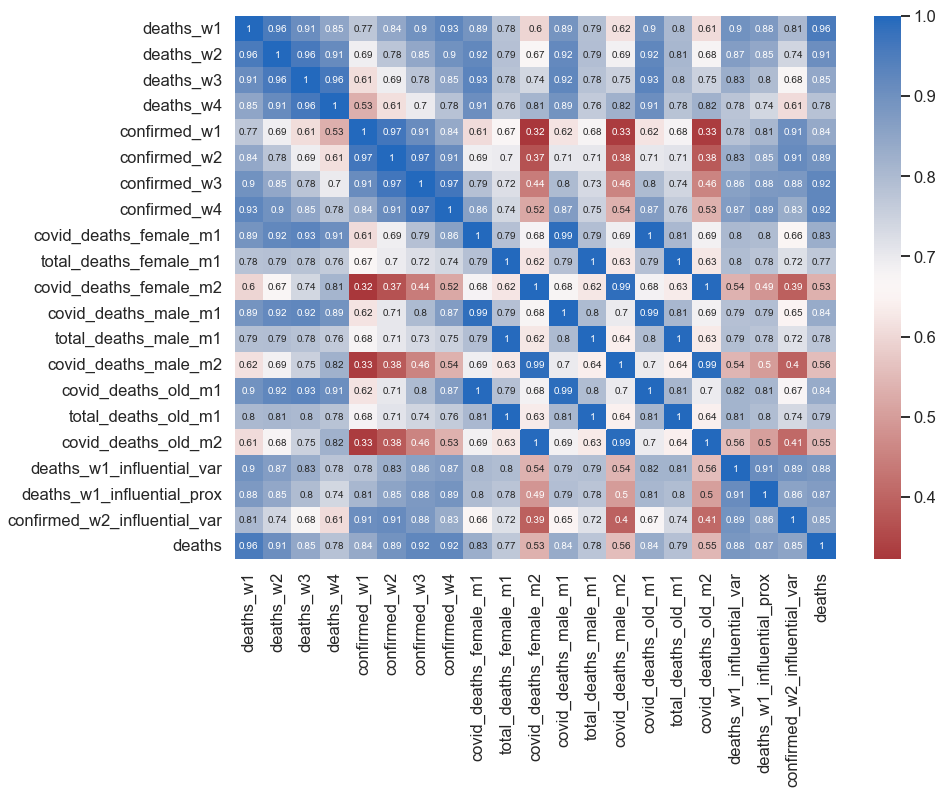

In [120]:
# Correlation matrix
fig = plt.figure(figsize=(12, 10))
#cmap = sns.color_palette("YlGnBu")
sns.heatmap(df_final.iloc[:, 6:].corr(), annot=True, cmap='vlag_r')
if include_plot_title:
    plt.title('Correlogram')
plt.savefig(f'{image_folder}correlogram.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');

<Figure size 1080x720 with 0 Axes>

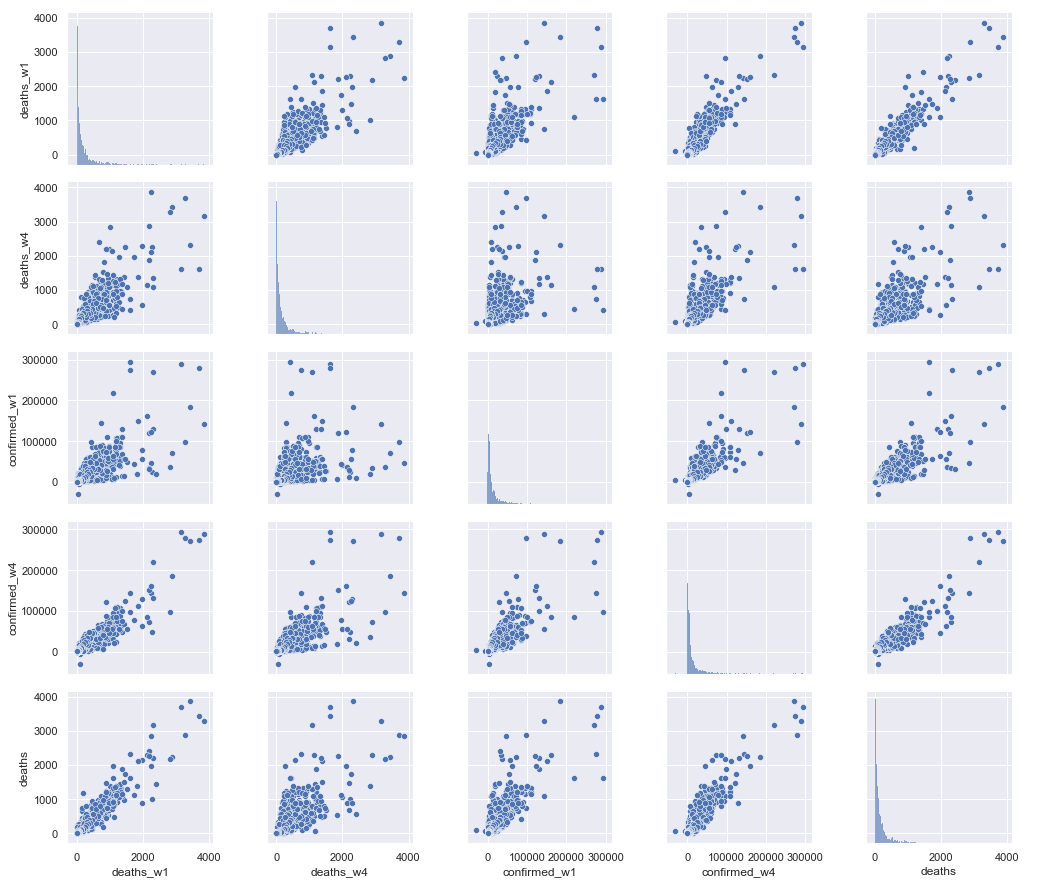

In [121]:
fig = plt.figure(figsize=(15, 10))
cols = ['deaths_w1', 'deaths_w4', 'confirmed_w1', 'confirmed_w4', 'deaths']
sns.set()
g = sns.pairplot(df_final[cols], aspect=1.2)
if include_plot_title:
    g.fig.suptitle('Interactions of deaths, lagged deaths and lagged confirmed cases', fontsize=20, y=1.01);
plt.savefig(f'{image_folder}pairplot1.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');

<Figure size 864x720 with 0 Axes>

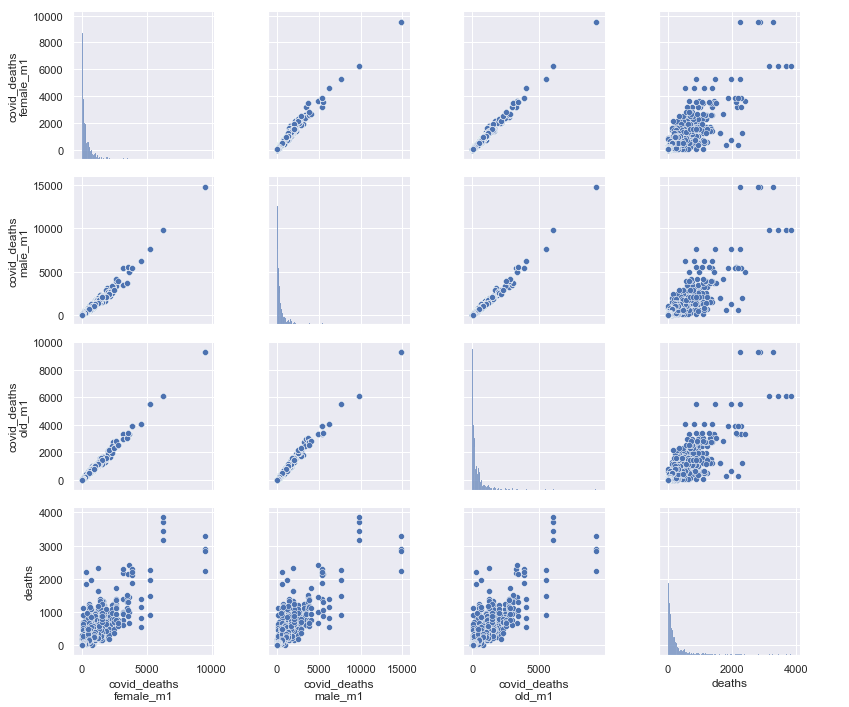

In [122]:
fig = plt.figure(figsize=(12, 10))
cols = ['covid_deaths_female_m1', 'covid_deaths_male_m1', 'covid_deaths_old_m1', 'deaths']
rename = {'covid_deaths_female_m1': 'covid_deaths\nfemale_m1',
          'covid_deaths_male_m1': 'covid_deaths\nmale_m1',
          'covid_deaths_old_m1': 'covid_deaths\nold_m1',
         }
g = sns.pairplot(df_final[cols].rename(columns=rename), aspect=1.2)
if include_plot_title:
    g.fig.suptitle('Interactions of deaths and 1-month lagged features', fontsize=20, y=1.01);
plt.savefig(f'{image_folder}pairplot2.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');

<Figure size 864x720 with 0 Axes>

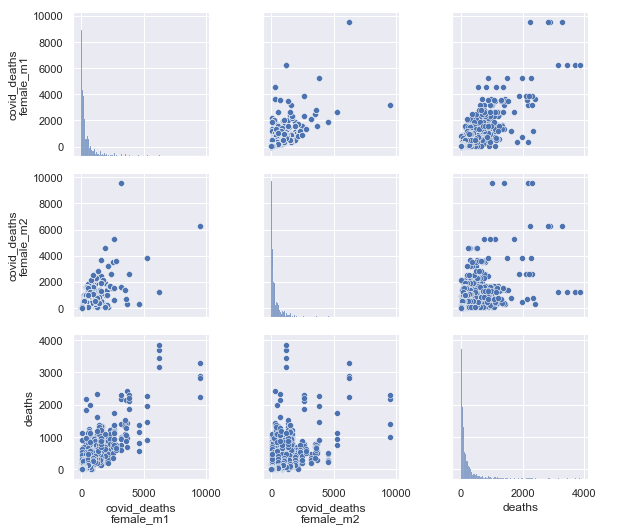

In [123]:
fig = plt.figure(figsize=(12, 10))
cols = ['covid_deaths_female_m1', 'covid_deaths_female_m2', 'deaths']
rename = {'covid_deaths_female_m1': 'covid_deaths\nfemale_m1',
          'covid_deaths_female_m2': 'covid_deaths\nfemale_m2'}
g = sns.pairplot(df_final[cols].rename(columns=rename), aspect=1.2)
if include_plot_title:
    g.fig.suptitle('Interactions of deaths and 2-month lagged features', fontsize=20, y=1.01)
plt.savefig(f'{image_folder}pairplot3.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');

<Figure size 864x720 with 0 Axes>

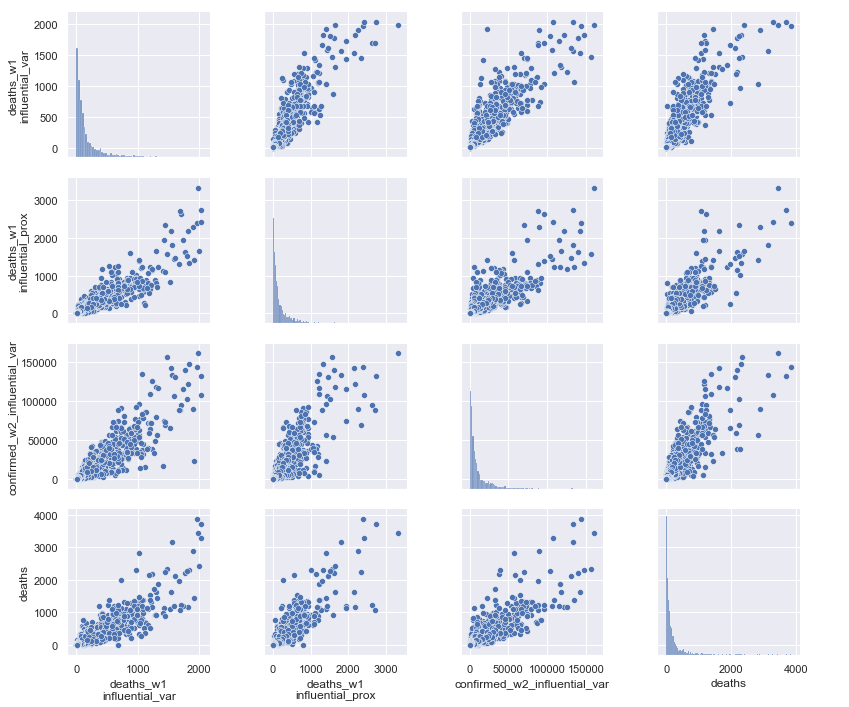

In [124]:
fig = plt.figure(figsize=(12, 10))
cols = ['deaths_w1_influential_var', 'deaths_w1_influential_prox',
        'confirmed_w2_influential_var', 'deaths']
rename = {'deaths_w1_influential_var': 'deaths_w1\ninfluential_var',
          'deaths_w1_influential_prox': 'deaths_w1\ninfluential_prox',
          'confirmed_w2_influential_prox': 'confirmed_w2\ninfluential_prox'}
g = sns.pairplot(df_final[cols].rename(columns=rename), aspect=1.2)
if include_plot_title:
    g.fig.suptitle('Interactions of deaths and 1-week lagged \nand scaled deaths of influential states', fontsize=20, y=1.05);
plt.savefig(f'{image_folder}pairplot4.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');

In [125]:
df_pivot = df_final.pivot_table(index='week_index', columns='state', values='deaths')
df_pivot.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
week_index,,,,,,,,,,,,,,,,,,,,,
1,80.0,0.0,57.0,24.0,491.0,148.0,571.0,79.0,75.0,309.0,...,11.0,32.0,239.0,8.0,5.0,180.0,83.0,16.0,68.0,0.0
2,102.0,1.0,202.0,16.0,507.0,135.0,496.0,69.0,71.0,351.0,...,13.0,34.0,200.0,17.0,3.0,210.0,90.0,4.0,64.0,0.0
3,95.0,0.0,147.0,10.0,521.0,225.0,407.0,83.0,64.0,249.0,...,10.0,53.0,278.0,12.0,0.0,176.0,72.0,12.0,55.0,0.0
4,64.0,0.0,122.0,17.0,530.0,135.0,336.0,53.0,52.0,269.0,...,6.0,34.0,159.0,19.0,1.0,156.0,51.0,8.0,54.0,5.0
5,69.0,0.0,103.0,18.0,406.0,116.0,237.0,53.0,35.0,214.0,...,12.0,35.0,182.0,15.0,1.0,211.0,42.0,3.0,81.0,4.0


In [126]:
df_pivot.shape

(48, 52)

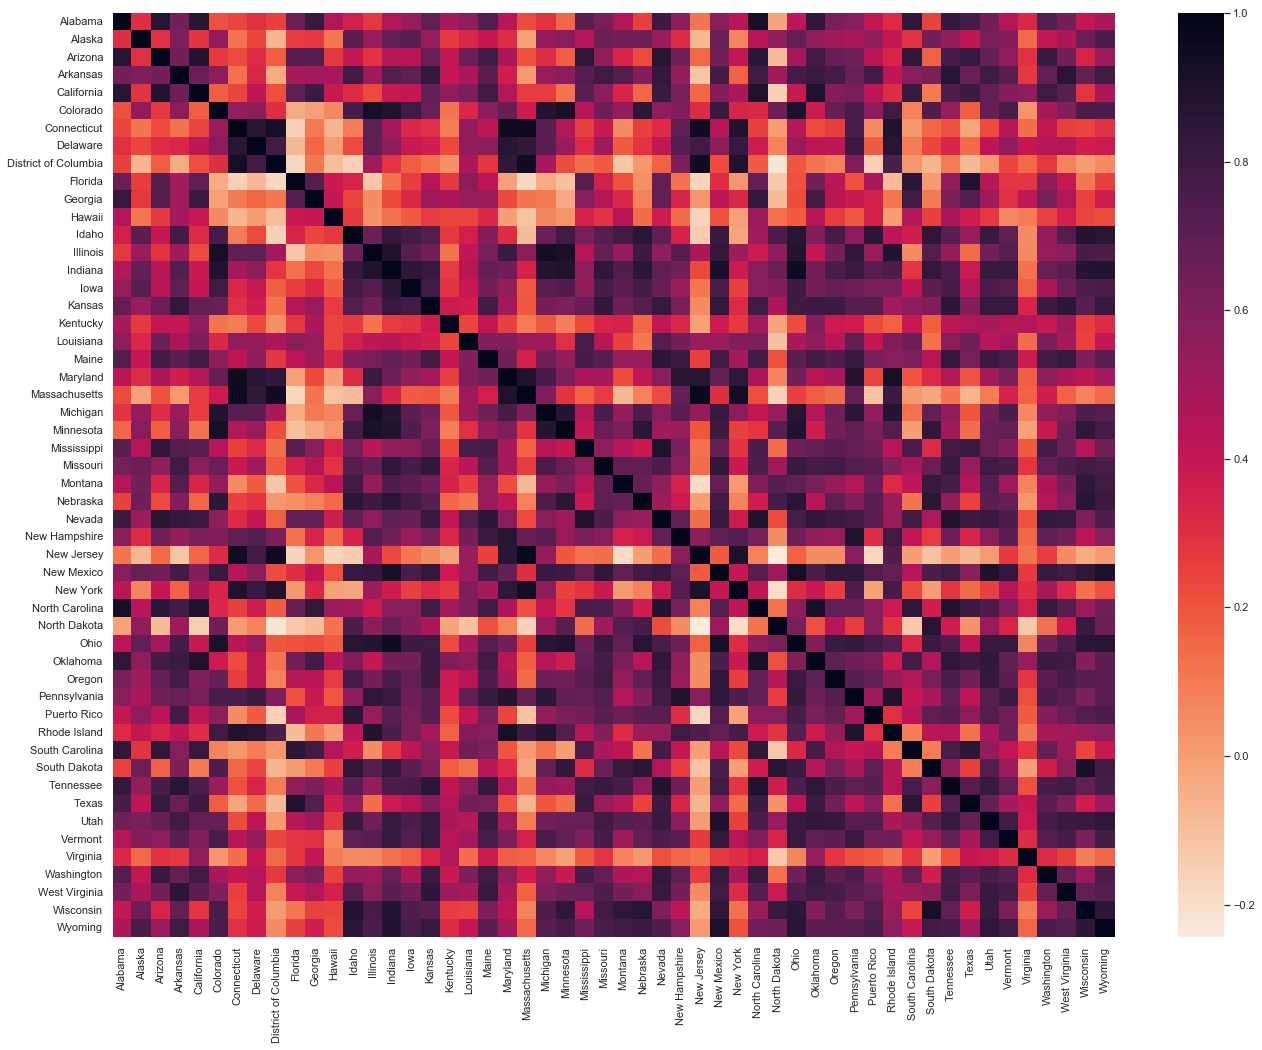

In [127]:
# Correlation matrix of deaths between states
fig = plt.figure(figsize=(20, 17))
sns.heatmap(df_pivot.corr(), cmap='rocket_r')
if include_plot_title:
    plt.title('Correlation of deaths between states')
plt.xlabel("")
plt.ylabel("")
plt.savefig(f'{image_folder}correlogram_states.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');

## Modeling

**Performance assessment:**

Model selection was based on training data results alone. We left the test set to compute the performance only after making our model decision. We computed two metrics, R squared and RMSE, using two methodologies we call train and cross-validation. We refer to train metrics as those obtained by using the whole training set to fit the model and also the whole training set to compute the metric. This metrics will be subject to overfitting. Cross-validation metrics intend to compute a better representation of out-of-sample performance using the training set only. For this we used 5-fold cross-validation. Even though we compute train metrics, our decision to choose a model was based on cross-validation metrics only.

We chose R squared because it is a widely used and easy to understand metric. Values close to 1 mean that 100\% of variability was captured by the model, while a value of 0 mean that the performance of the model is equivalent to using the mean as a forecasting model. We also chose RMSE as it can be thought of a weighted average of errors (in deaths) that are weighted more heavily to larger errors. This is because the metric first squares the error, before averaging and taking square root, which exacerbates notable misses. We thought RMSE was a good addition to our evaluation tool kit because RMSE is easy to interpret and also because the units are the same as the target, deaths in this case.


**Feature selection:**

We considered three main methodologies for selecting the features of our model: LASSO, linear regression p-values, and cross-validated metrics.

LASSO uses L1 regularization which has the nice property of quickly eliminating features that do not contribute highly enough to decrease MSE. There is a regularization parameter (alpha in sklearn) that controls the trade-off between MSE and the L1 norm of coefficients. Our methodology here was based on plotting the coefficient values for different values of alpha. Since we want LASSO to eliminate only clearly useless features,
we used a small alpha in LASSO in order not to zero out too many features. LASSO is incredibly powerful for feature selection, specially because its execution time is extremely low. It is a great tool for doing a initial selection of features, specially if the number of features considered is relatively large.


In linear regression, we check whether these LASSO features are significant by looking at the t-stat and related p-values of the fitted coefficients for these features. High p-values indicate that we cannot reject that the coefficient accompanying the variable is equal to zero, i.e. the feature is not statistically significant. Removing a feature with a high p-value of the t-test could improve cross-validation metrics, but it is not guaranteed. This methodology also allows to start from a model with more features than those selected by LASSO and then use the p-value as a guide to prune the model into one that generalizes better out-of-sample data.

Ultimately, it is cross-validation performance the driver for decisions. LASSO and linear regression p-values are used as a guide to trying promising models, but the final model selection is based on cross-validated R squared and RMSE.

**Models:**

We propose several models for the death forecast task. The first to consider is ordinary linear regression (OLS). This is a natural choice since we observe clear linear correlations between the lagged death statistics and the target, which was discussed in detail in Sec.~2.4. The second model to consider is Ridge regression. Ridge regression adds a $L_2$-norm regularization term to the OLS, so as to penalize the size of the model coefficients, thus possibly reducing the number of features used. This also allows us to determine which features are useful or not. Some co-linear features may be reduced when using Ridge regression. The third model to experiment on is the LASSO regression, which adds an $L_1$-norm to the OLS. This regularization is more aggressive in setting some coefficients to zero than Ridge regression, which is expected to help in the feature selection. The fourth model to try is the Elastic Net. It  is a regularized regression method that linearly combines the $L_1$ and $L_2$ penalties of the LASSO and Ridge regression. We will also try Random Forest regression which is an ensemble learning method for regression that combines bootstrapping of the dataset and the bagging of many decision trees trained on the bootstrapped dataset. The last model to consider is the Gradient Boosted regression. This model creates decision trees in sequence where each new tree classifies and improves on the residuals of the previous tree. 

**Hyperparameter tuning**

For both LASSO and Ridge regressions, we have the hyperparameter alpha -- the regularization coefficient. We tune the hyperparameter by either doing a linear grid search and choose the alpha that gives the best 5-fold cross-validation RMSE. We also use grid search to choose the hyperparameters of Elastic Net, Random Forest regression, and Gradient Boosted regression. 

For Elastic Net we consider alpha and l1\_ratio in the grid, the second being the trade-off between L1 and L2 regularization. With l1\_ratio of 1 it is in essence running a LASSO regression while a value of 0 is in essence running a Ridge regression (with some slightly different scaling). 

For Random Forest regression we included the number of estimators (trees) and the maximum depth (of each tree) into the hyperparameter grid, two choices that greatly affect the dynamics of the model. Similarly, for Gradient Bossted regression we searched over the number of estimators using cross-validate grid search.

In [128]:
def my_cv(model, X, y, cv, scoring):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    cv_result = {}
    for metric in scoring:
        cv_result[metric] = scores[f"test_{metric}"].mean()
        if metric == 'neg_mean_squared_error':
            cv_result['rmse'] = np.sqrt(-scores[f"test_{metric}"].mean())
    return cv_result

In [129]:
def scatter_pred_vs_target(pred, target, name_file=None):
    fig, ax = plt.subplots(figsize=(10,8))
    xmin = min(pred.min(), target.min())
    xmax = max(pred.max(), target.max())
    plt.scatter(pred, target, alpha=0.5)
    vec = np.linspace(xmin, xmax*1.01, 1000)
    ax.plot(vec, vec, color='red')
    if include_plot_title:
        ax.set_title('Fitted vs target', fontsize=15)
    ax.set_xlabel('Fitted weekly deaths', fontsize=15)
    ax.set_ylabel('Weekly deaths', fontsize=15)
    if name_file is not None:
        plt.savefig(f'{image_folder}{name_file}.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');
    plt.show()

In [130]:
def get_performance(clf, scalerY, X_true, y_true_sc, y_train_sc=None, fitted_sc=None, 
                    cv=5, scoring=('r2', 'neg_mean_squared_error'), plot_file_name=None):

    # RMSE fitted
    if fitted_sc is None:
        fitted_sc = clf.predict(X_true)
    fitted = scalerY.inverse_transform(fitted_sc.reshape(-1,1))
    y_true = scalerY.inverse_transform(y_true_sc)
    rmse_fitted = np.sqrt(np.mean((y_true - fitted)**2))    

    # R squared fitted
    if y_train_sc is not None:
        y_train = scalerY.inverse_transform(y_train_sc)
        mu = np.mean(y_train)
    else:
        mu = np.mean(y_true)
    r2_fitted = 1 - np.sum((y_true - fitted)**2)/np.sum((y_true - mu)**2)

    # Plot
    scatter_pred_vs_target(fitted, y_true, plot_file_name)
    
    cv_res = my_cv(clf, X_true, y_true, cv, scoring)
    df_res = pd.DataFrame([[r2_fitted, rmse_fitted], [cv_res['r2'], cv_res['rmse']]], 
                         index=['Fitted', 'Cross-Validated'],
                         columns=['R squared', 'RMSE'])
    
    return df_res

#### Data Split

In [131]:
df_final.shape

(2470, 27)

In [132]:
def get_regression_df(columns, week_index_test_start=41):
    
    df_xy = (df_final \
        .loc[:, columns]
        .dropna()
    )
    df_xy_train = df_xy[df_xy.week_index < week_index_test_start]
    df_xy_test = df_xy[df_xy.week_index >= week_index_test_start]
    df_xy_train.drop(columns='week_index', inplace=True)
    df_xy_test.drop(columns='week_index', inplace=True)

    # Train
    X_train = df_xy_train.iloc[:, :-1]
    y_train = df_xy_train.iloc[:, [-1]]

    # Test
    X_test = df_xy_test.iloc[:, :-1]
    y_test = df_xy_test.iloc[:, [-1]]

    # Standardize data
    scalerX = MinMaxScaler()
    scalerY = MinMaxScaler()
    X_train_sc = pd.DataFrame(scalerX.fit_transform(X_train), columns=X_train.columns)
    y_train_sc = pd.DataFrame(scalerY.fit_transform(y_train), columns=y_train.columns)
    X_test_sc = pd.DataFrame(scalerX.transform(X_test), columns=X_test.columns)
    y_test_sc = pd.DataFrame(scalerY.transform(y_test), columns=y_test.columns)
    
    print(f"X_train.shape: {X_train.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"y_test.shape: {y_test.shape}")
    
    return X_train_sc, X_test_sc, y_train_sc, y_test_sc, scalerX, scalerY

In [133]:
variables_to_test = [col for col in df_final.loc[:, 'deaths_w1':].columns if '_m2' not in col]
X_train, X_test, y_train, y_test, scalerX, scalerY = get_regression_df(['week_index'] + variables_to_test)
X_train.head()

X_train.shape: (1683, 17)
X_test.shape: (305, 17)
y_train.shape: (1683, 1)
y_test.shape: (305, 1)


,deaths_w1,deaths_w2,deaths_w3,deaths_w4,confirmed_w1,confirmed_w2,confirmed_w3,confirmed_w4,covid_deaths_female_m1,total_deaths_female_m1,covid_deaths_male_m1,total_deaths_male_m1,covid_deaths_old_m1,total_deaths_old_m1,deaths_w1_influential_var,deaths_w1_influential_prox,confirmed_w2_influential_var
0,0.016598,0.025669,0.027560,0.025349,0.099592,0.098382,0.098110,0.096276,0.01962,0.108196,0.016699,0.093268,0.019272,0.104542,0.055157,0.033087,0.011933
1,0.017894,0.017293,0.025669,0.032319,0.102250,0.099592,0.098382,0.098110,0.02623,0.117009,0.018187,0.098241,0.022179,0.106549,0.045987,0.030793,0.011782
2,0.018413,0.018644,0.017293,0.030101,0.100104,0.102250,0.099592,0.098382,0.02623,0.117009,0.018187,0.098241,0.022179,0.106549,0.032670,0.028390,0.012316
3,0.021784,0.019184,0.018644,0.020279,0.107338,0.100104,0.102250,0.099592,0.02623,0.117009,0.018187,0.098241,0.022179,0.106549,0.032986,0.032583,0.012554
4,0.016857,0.022697,0.019184,0.021863,0.105207,0.107338,0.100104,0.102250,0.02623,0.117009,0.018187,0.098241,0.022179,0.106549,0.024597,0.023084,0.015540


In [134]:
y_train.head()

,deaths
0,0.017894
1,0.018413
2,0.021784
3,0.016857
4,0.021006


#### Benchmark

The Benchmark is a simple but effective model: predict that next week the number of Covid-19 deaths will be based only on this week's Covid-19 deaths (and will basically forecast the same number).

In [135]:
X0_train = X_train[['deaths_w1']]
model = linear_model.LinearRegression(fit_intercept=False)
clf_reg0 = model.fit(X0_train, y_train.deaths)

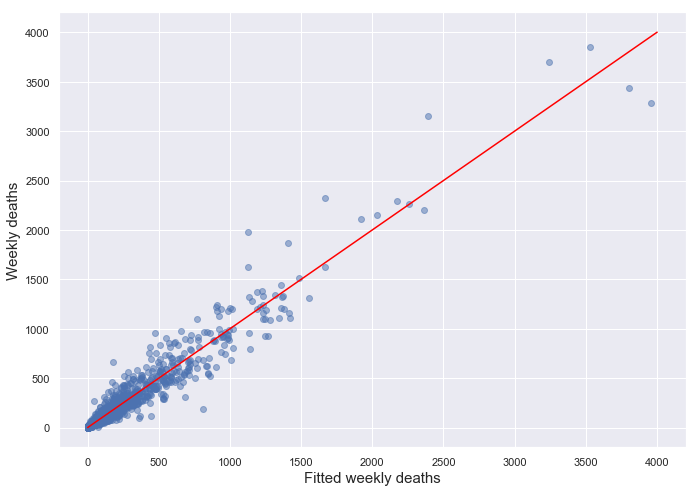

,R squared,RMSE
Fitted,0.936697,84.846458
Cross-Validated,0.913169,85.583463


In [136]:
df_res_bench = get_performance(clf_reg0, scalerY, X0_train, y_train.to_numpy(), plot_file_name="train_bench_fitted")
df_res_bench

This model basically forecasts for week w in state s almost the same amount of deaths that ocurred in week w-1 in state s.

Even though the data has a temporal component, it is better to use a cross-validated metric, than a metric evaluated over the model fitted on the entire training set. The training R squared was 93.6% and the cross-validated R squared was 91.3%. We will use the latter as our best reference using the training data alone. The cross-validated RMSE was 85.6 deaths, which looks reasonably small since we are talking about state wide deaths.

#### LASSO

Used here for an initial quick feature selection. LASSO will zero out many variables depending on the regularization coefficient alpha (the higher the stronger the regularization). Later on we will use our chosen variables on linear regression (no regularization), on Ridge regression (L2 regularization) and Elastic Net (both L1 and L2 regularization).

In [137]:
clf_lasso = linear_model.Lasso(alpha=1e-3)
clf_lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [138]:
clf_lasso.coef_

array([0.5168, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0214, 0.    , 0.    , 0.    , 0.    , 0.0983, 0.    ,
       0.1475])

In [139]:
# We drop some variables we know already are higly correlated with _old
X_train_lasso = X_train.drop(columns=['covid_deaths_female_m1', 
                                      'total_deaths_female_m1', 
                                      'covid_deaths_male_m1', 
                                      'total_deaths_male_m1'])
#.drop(columns=['confirmed_w1', 'confirmed_w2', 'confirmed_w3'])
X_train_lasso.head()

,deaths_w1,deaths_w2,deaths_w3,deaths_w4,confirmed_w1,confirmed_w2,confirmed_w3,confirmed_w4,covid_deaths_old_m1,total_deaths_old_m1,deaths_w1_influential_var,deaths_w1_influential_prox,confirmed_w2_influential_var
0,0.016598,0.025669,0.027560,0.025349,0.099592,0.098382,0.098110,0.096276,0.019272,0.104542,0.055157,0.033087,0.011933
1,0.017894,0.017293,0.025669,0.032319,0.102250,0.099592,0.098382,0.098110,0.022179,0.106549,0.045987,0.030793,0.011782
2,0.018413,0.018644,0.017293,0.030101,0.100104,0.102250,0.099592,0.098382,0.022179,0.106549,0.032670,0.028390,0.012316
3,0.021784,0.019184,0.018644,0.020279,0.107338,0.100104,0.102250,0.099592,0.022179,0.106549,0.032986,0.032583,0.012554
4,0.016857,0.022697,0.019184,0.021863,0.105207,0.107338,0.100104,0.102250,0.022179,0.106549,0.024597,0.023084,0.015540


In [140]:
alphas = np.linspace(0,1e-2, 201)
lasso = linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_lasso, y_train)
    coefs.append(lasso.coef_)

res_lasso = pd.DataFrame(coefs, columns=X_train_lasso.columns, index=alphas)

In [141]:
alpha_chosen = 5e-04
index_chosen = np.where(alphas == alpha_chosen)[0][0]
threshold = 0.001
res_lasso_filt = res_lasso.iloc[index_chosen]
res_lasso_filt = res_lasso_filt[res_lasso_filt.abs() > threshold]
res_lasso_filt

deaths_w1                       0.623893
confirmed_w1                    0.018944
confirmed_w2                    0.119967
confirmed_w3                    0.005263
total_deaths_old_m1             0.021834
deaths_w1_influential_var       0.035109
confirmed_w2_influential_var    0.103228
Name: 0.0005, dtype: float64

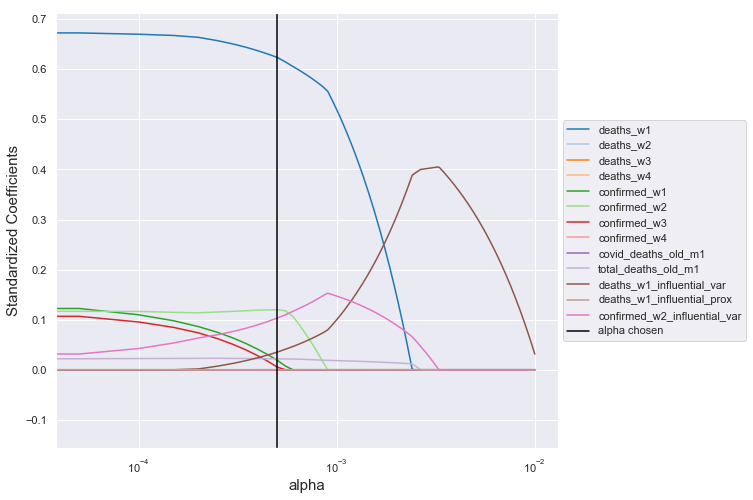

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
res_lasso.plot(ax=ax, color=sns.color_palette("tab20"))
plt.axvline(x=alpha_chosen, color='black', label='alpha chosen')
ax.set_xscale('log')

# Put legend outside
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('tight')
plt.xlabel('alpha', fontsize=15)
plt.ylabel('Standardized Coefficients', fontsize=15)
if include_plot_title:
    plt.title('Lasso coefficients as a function of alpha', fontsize=15)

plt.savefig(f'{image_folder}lasso.eps', format='eps', bbox_inches='tight', facecolor='white', 
            edgecolor='none');

We choose a rather small alpha in order to not limit too much the number of variables. We will do further feature selection based on model results in the next steps.

In [143]:
lasso_vars = list(res_lasso_filt.index)
lasso_vars

['deaths_w1',
 'confirmed_w1',
 'confirmed_w2',
 'confirmed_w3',
 'total_deaths_old_m1',
 'deaths_w1_influential_var',
 'confirmed_w2_influential_var']

#### Linear Regression

In [144]:
def linear_reg_performance(variables, X_train, y_train, scalerY, fit_intercept=True):

    # Sklearn's implementation
    model = linear_model.LinearRegression(fit_intercept=fit_intercept)
    clf_reg = model.fit(X_train[variables], y_train.deaths)

    # Display coefficients
    print("\nSklearn coefficients:")
    display(pd.DataFrame(clf_reg.coef_, index=variables, columns=['Coef'])
            .reset_index().rename(columns={'index': 'Feature'}))
    
    # Compute performance and plot
    df_res = get_performance(clf_reg, scalerY, X_train[variables], y_train.to_numpy())
    print("\nPerformance")
    display(df_res)
    
    # Statsmodels for inference
    print("\nStatsmodels statistical test results")
    mod = sm.OLS(y_train, X_train[variables])
    sm_res = mod.fit()
    return clf_reg, df_res, sm_res


Sklearn coefficients:


,Feature,Coef
0,deaths_w1,0.690657
1,confirmed_w1,0.133374
2,confirmed_w2,0.105294
3,confirmed_w3,0.120991
4,total_deaths_old_m1,0.023808
5,deaths_w1_influential_var,-0.020768
6,confirmed_w2_influential_var,0.036778


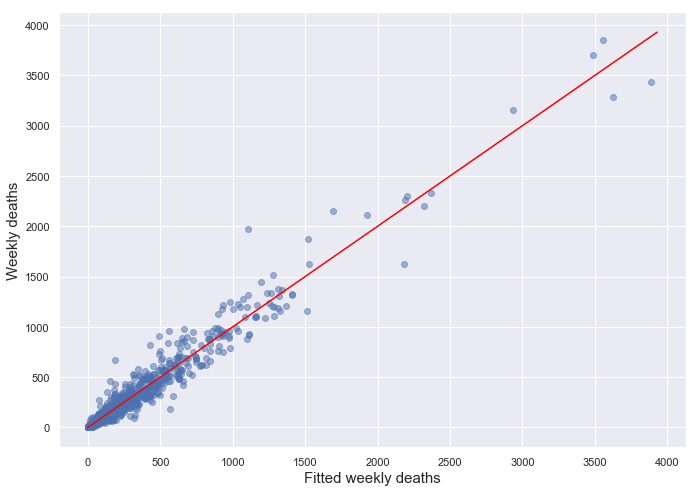


Performance


,R squared,RMSE
Fitted,0.95836,68.814290
Cross-Validated,0.94018,71.249307



Statsmodels statistical test results


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 deaths   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              6277.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                        0.00
Time:                        21:41:04   Log-Likelihood:                          4240.0
No. Observations:                1683   AIC:                                     -8466.
Df Residuals:                    1676   BIC:                                     -8428.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
deaths_w1                        0.9105      0.015     59.311      0.000       0.880       0.941
confirmed_w1                     0.0811      0.027      2.961      0.003       0.027       0.135
confirmed_w2                     0.0121      0.044      0.275      0.783      -0.074       0.099
confirmed_w3                    -0.0723      0.030     -2.377      0.018      -0.132      -0.013
total_deaths_old_m1              0.0026      0.007      0.389      0.697      -0.010       0.016
deaths_w1_influential_var       -0.0934      0.013     -7.149      0.000      -0.119      -0.068
confirmed_w2_influential_var     0.1712      0.013     13.504      0.000       0.146       0.196
==============================================================================
Omnibus:                      891.262   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35828.646
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                      25.314   Cond. No.                         42.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
# Linear regression with features indicated by LASSO
clf_reg_lasso_vars, df_res_lasso_vars, sm_res_lasso_vars = linear_reg_performance(lasso_vars, X_train, y_train, scalerY)
sm_res_lasso_vars.summary()

In [146]:
df_sm_res_lasso_vars = pd.DataFrame(sm_res_lasso_vars.summary().tables[1])
df_sm_res_lasso_vars.columns = df_sm_res_lasso_vars.loc[0]
df_sm_res_lasso_vars = df_sm_res_lasso_vars.loc[1:]
df_sm_res_lasso_vars = df_sm_res_lasso_vars.iloc[:, :5]
print(df_sm_res_lasso_vars.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
                              &        coef &    std err &          t &   P>|t| \\
\midrule
                    deaths\_w1 &      0.9105 &      0.015 &     59.311 &   0.000 \\
                 confirmed\_w1 &      0.0811 &      0.027 &      2.961 &   0.003 \\
                 confirmed\_w2 &      0.0121 &      0.044 &      0.275 &   0.783 \\
                 confirmed\_w3 &     -0.0723 &      0.030 &     -2.377 &   0.018 \\
          total\_deaths\_old\_m1 &      0.0026 &      0.007 &      0.389 &   0.697 \\
    deaths\_w1\_influential\_var &     -0.0934 &      0.013 &     -7.149 &   0.000 \\
 confirmed\_w2\_influential\_var &      0.1712 &      0.013 &     13.504 &   0.000 \\
\bottomrule
\end{tabular}




Sklearn coefficients:


,Feature,Coef
0,deaths_w1,0.679531
1,deaths_w2,0.078950
2,deaths_w3,-0.043131
3,deaths_w4,-0.021629
4,confirmed_w1,0.145589
5,confirmed_w2,0.063760
6,confirmed_w3,0.144929
7,confirmed_w4,-0.010377
8,covid_deaths_old_m1,-0.001626
9,total_deaths_old_m1,0.027641


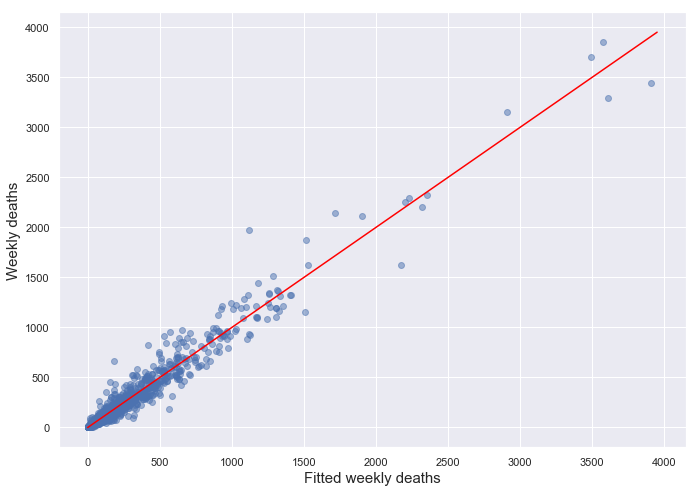


Performance


,R squared,RMSE
Fitted,0.958580,68.632262
Cross-Validated,0.938898,72.044436



Statsmodels statistical test results


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 deaths   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              3868.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                        0.00
Time:                        21:41:05   Log-Likelihood:                          4286.8
No. Observations:                1683   AIC:                                     -8550.
Df Residuals:                    1671   BIC:                                     -8485.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
deaths_w1                        0.8484      0.028     30.836      0.000       0.794       0.902
deaths_w2                        0.1327      0.036      3.662      0.000       0.062       0.204
deaths_w3                       -0.0707      0.037     -1.923      0.055      -0.143       0.001
deaths_w4                       -0.0758      0.023     -3.312      0.001      -0.121      -0.031
confirmed_w1                     0.0912      0.030      2.995      0.003       0.031       0.151
confirmed_w2                    -0.0040      0.047     -0.084      0.933      -0.097       0.089
confirmed_w3                     0.1424      0.047      3.032      0.002       0.050       0.234
confirmed_w4                    -0.2135      0.034     -6.226      0.000      -0.281      -0.146
covid_deaths_old_m1              0.0770      0.022      3.424      0.001       0.033       0.121
total_deaths_old_m1              0.0102      0.007      1.427      0.154      -0.004       0.024
deaths_w1_influential_var       -0.0470      0.014     -3.415      0.001      -0.074      -0.020
confirmed_w2_influential_var     0.1136      0.014      8.199      0.000       0.086       0.141
==============================================================================
Omnibus:                      761.404   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26218.484
Skew:                           1.461   Prob(JB):                         0.00
Kurtosis:                      22.114   Cond. No.                         59.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
# Deaths, Confirmed, Old, Influential
dcoi_cols = ['deaths_w1', 'deaths_w2', 'deaths_w3', 'deaths_w4', 
               'confirmed_w1', 'confirmed_w2', 'confirmed_w3', 'confirmed_w4', 
               'covid_deaths_old_m1', 'total_deaths_old_m1', 
               'deaths_w1_influential_var', 'confirmed_w2_influential_var']
clf_reg_dcoi, df_res_dcoi, sm_res_dcoi = linear_reg_performance(dcoi_cols, X_train, y_train, scalerY)
sm_res_dcoi.summary()


Sklearn coefficients:


,Feature,Coef
0,deaths_w1,0.675495
1,deaths_w2,0.083627
2,deaths_w3,-0.042816
3,deaths_w4,-0.014092
4,confirmed_w1,0.168143
5,confirmed_w2,0.059494
6,confirmed_w3,0.139718
7,confirmed_w4,-0.028362
8,covid_deaths_old_m1,0.022237
9,deaths_w1_influential_var,-0.006068


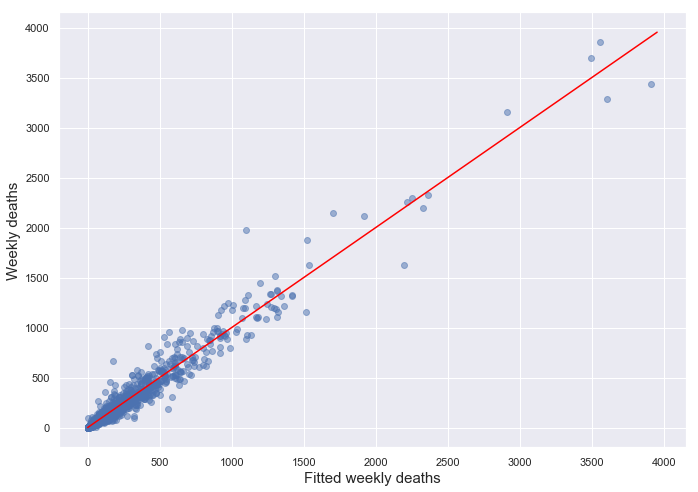


Performance


,R squared,RMSE
Fitted,0.958171,68.970017
Cross-Validated,0.938681,71.973689



Statsmodels statistical test results


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 deaths   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              4216.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                        0.00
Time:                        21:41:05   Log-Likelihood:                          4285.8
No. Observations:                1683   AIC:                                     -8550.
Df Residuals:                    1672   BIC:                                     -8490.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
deaths_w1                        0.8439      0.027     30.868      0.000       0.790       0.898
deaths_w2                        0.1335      0.036      3.684      0.000       0.062       0.205
deaths_w3                       -0.0701      0.037     -1.906      0.057      -0.142       0.002
deaths_w4                       -0.0719      0.023     -3.166      0.002      -0.117      -0.027
confirmed_w1                     0.1008      0.030      3.390      0.001       0.042       0.159
confirmed_w2                    -0.0044      0.047     -0.093      0.926      -0.097       0.088
confirmed_w3                     0.1404      0.047      2.991      0.003       0.048       0.233
confirmed_w4                    -0.2167      0.034     -6.331      0.000      -0.284      -0.150
covid_deaths_old_m1              0.0847      0.022      3.876      0.000       0.042       0.127
deaths_w1_influential_var       -0.0441      0.014     -3.239      0.001      -0.071      -0.017
confirmed_w2_influential_var     0.1128      0.014      8.145      0.000       0.086       0.140
==============================================================================
Omnibus:                      763.131   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26899.297
Skew:                           1.459   Prob(JB):                         0.00
Kurtosis:                      22.367   Cond. No.                         55.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
# Deaths, Confirmed, Old, Influential (without total_deaths_old_m1)
dcoi2_cols = ['deaths_w1', 'deaths_w2', 'deaths_w3', 'deaths_w4', 
               'confirmed_w1', 'confirmed_w2', 'confirmed_w3', 'confirmed_w4', 
               'covid_deaths_old_m1', 'deaths_w1_influential_var', 'confirmed_w2_influential_var']
clf_reg_dcoi2, df_res_dcoi2, sm_res_dcoi2 = linear_reg_performance(dcoi2_cols, X_train, y_train, scalerY)
sm_res_dcoi2.summary()


Sklearn coefficients:


,Feature,Coef
0,deaths_w1,0.673109
1,deaths_w2,0.100066
2,deaths_w3,-0.050725
3,deaths_w4,-0.013897
4,confirmed_w1,0.194512
5,confirmed_w3,0.168922
6,confirmed_w4,-0.027729
7,covid_deaths_old_m1,0.017164
8,deaths_w1_influential_var,-0.008464
9,confirmed_w2_influential_var,0.033644


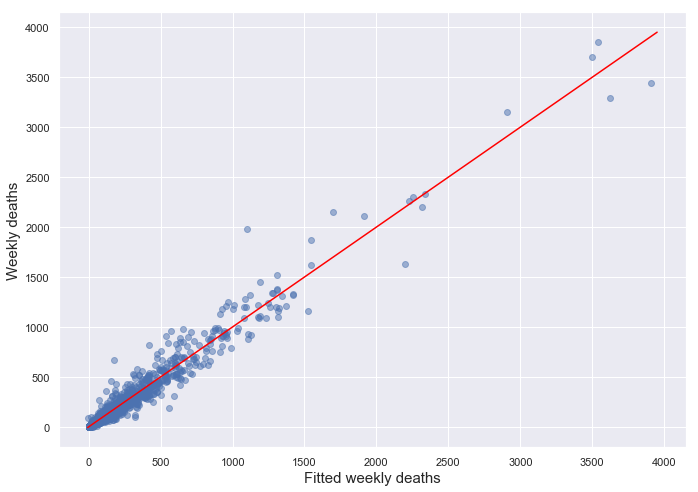


Performance


,R squared,RMSE
Fitted,0.958127,69.006404
Cross-Validated,0.938888,71.865019



Statsmodels statistical test results


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 deaths   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              4641.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                        0.00
Time:                        21:41:05   Log-Likelihood:                          4285.8
No. Observations:                1683   AIC:                                     -8552.
Df Residuals:                    1673   BIC:                                     -8497.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
deaths_w1                        0.8442      0.027     31.095      0.000       0.791       0.897
deaths_w2                        0.1323      0.034      3.904      0.000       0.066       0.199
deaths_w3                       -0.0695      0.036     -1.918      0.055      -0.141       0.002
deaths_w4                       -0.0720      0.023     -3.170      0.002      -0.117      -0.027
confirmed_w1                     0.0988      0.020      4.846      0.000       0.059       0.139
confirmed_w3                     0.1383      0.041      3.399      0.001       0.058       0.218
confirmed_w4                    -0.2169      0.034     -6.348      0.000      -0.284      -0.150
covid_deaths_old_m1              0.0851      0.021      3.983      0.000       0.043       0.127
deaths_w1_influential_var       -0.0440      0.014     -3.252      0.001      -0.071      -0.017
confirmed_w2_influential_var     0.1126      0.014      8.226      0.000       0.086       0.139
==============================================================================
Omnibus:                      762.980   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26870.905
Skew:                           1.459   Prob(JB):                         0.00
Kurtosis:                      22.357   Cond. No.                         44.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
# Deaths, Confirmed, Old, Influential Lean (only signficant variables)
dcoil_cols = ['deaths_w1', 'deaths_w2', 'deaths_w3', 'deaths_w4', 
               'confirmed_w1', 'confirmed_w3', 'confirmed_w4', 
               'covid_deaths_old_m1', 'deaths_w1_influential_var',
               'confirmed_w2_influential_var']
clf_reg_dcoil, df_res_dcoil, sm_res_dcoil = linear_reg_performance(dcoil_cols, X_train, y_train, scalerY)
sm_res_dcoil.summary()

In [150]:
df_sm_res_lasso_vars = pd.DataFrame(sm_res_dcoil.summary().tables[1])
df_sm_res_lasso_vars.columns = df_sm_res_lasso_vars.loc[0]
df_sm_res_lasso_vars = df_sm_res_lasso_vars.loc[1:]
df_sm_res_lasso_vars = df_sm_res_lasso_vars.iloc[:, :5]
print(df_sm_res_lasso_vars.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
                              &        coef &    std err &          t &   P>|t| \\
\midrule
                    deaths\_w1 &      0.8442 &      0.027 &     31.095 &   0.000 \\
                    deaths\_w2 &      0.1323 &      0.034 &      3.904 &   0.000 \\
                    deaths\_w3 &     -0.0695 &      0.036 &     -1.918 &   0.055 \\
                    deaths\_w4 &     -0.0720 &      0.023 &     -3.170 &   0.002 \\
                 confirmed\_w1 &      0.0988 &      0.020 &      4.846 &   0.000 \\
                 confirmed\_w3 &      0.1383 &      0.041 &      3.399 &   0.001 \\
                 confirmed\_w4 &     -0.2169 &      0.034 &     -6.348 &   0.000 \\
          covid\_deaths\_old\_m1 &      0.0851 &      0.021 &      3.983 &   0.000 \\
    deaths\_w1\_influential\_var &     -0.0440 &      0.014 &     -3.252 &   0.001 \\
 confirmed\_w2\_influential\_var &      0.1126 &      0.014 &      8.226 &   0.000 \\
\bottomrule
\end{tabular}



#### Ridge

In [151]:
# Ridge regression (with all reasonable initial variables, just in case)
parameters = {'alpha': np.linspace(0, 1, 41)}
model = linear_model.Ridge(random_state=42)
clf_rdg_grid = GridSearchCV(model, parameters, cv=5, verbose=1)
clf_rdg_grid.fit(X_train_lasso, y_train)
clf_rdg_full = clf_rdg_grid.best_estimator_
print(f"best params: {clf_rdg_grid.best_params_}")

Fitting 5 folds for each of 41 candidates, totalling 205 fits
best params: {'alpha': 0.025}


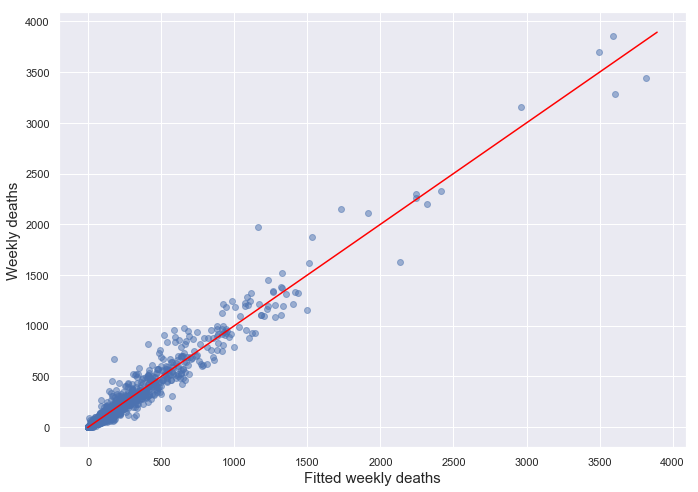

,R squared,RMSE
Fitted,0.959667,67.725435
Cross-Validated,0.939791,70.574534


In [152]:
df_res_rdg_full = get_performance(clf_rdg_full, scalerY, X_train_lasso, y_train.to_numpy())
df_res_rdg_full

In [153]:
coef_rdg = pd.DataFrame(clf_rdg_full.coef_, columns=X_train_lasso.columns, index=['Coef']).T \
            .reset_index().rename(columns={'index': 'Feature'})
coef_rdg

,Feature,Coef
0,deaths_w1,0.627792
1,deaths_w2,0.096285
2,deaths_w3,-0.023336
3,deaths_w4,-0.027191
4,confirmed_w1,0.177966
5,confirmed_w2,0.080440
6,confirmed_w3,0.116096
7,confirmed_w4,0.055907
8,covid_deaths_old_m1,0.002443
9,total_deaths_old_m1,0.033943


In [154]:
# Ridge regression with only features selected by LASSO
parameters = {'alpha': np.linspace(0, 1, 81)}
model = linear_model.Ridge(random_state=42)
clf_rdg_grid = GridSearchCV(model, parameters, cv=5, verbose=1)
clf_rdg_grid.fit(X_train[lasso_vars], y_train)
clf_rdg = clf_rdg_grid.best_estimator_
print(f"best params: {clf_rdg_grid.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
best params: {'alpha': 0.05}


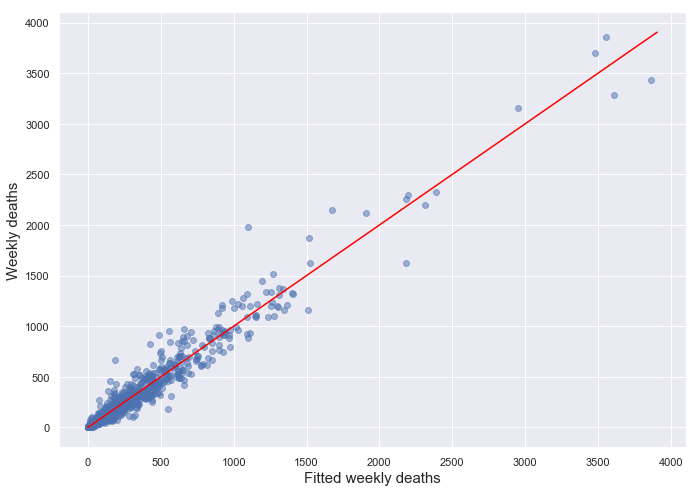

,R squared,RMSE
Fitted,0.958288,68.873794
Cross-Validated,0.940343,71.456937


In [155]:
df_res_rdg_lasso_vars = get_performance(clf_rdg, scalerY, X_train[lasso_vars], y_train.to_numpy(), 
                                        plot_file_name="train_ridge_fitted")
df_res_rdg_lasso_vars

In [156]:
coef_rdg = pd.DataFrame(clf_rdg.coef_, columns=lasso_vars, index=['Coef']).T \
            .reset_index().rename(columns={'index': 'Feature'})
coef_rdg

,Feature,Coef
0,deaths_w1,0.659363
1,confirmed_w1,0.126142
2,confirmed_w2,0.116271
3,confirmed_w3,0.135247
4,total_deaths_old_m1,0.026495
5,deaths_w1_influential_var,-0.008918
6,confirmed_w2_influential_var,0.031332


The simpler model with a little L2 regularization is better than all previous models.

In [157]:
df_final[['deaths_w1', 'confirmed_w1']].mean()

deaths_w1         201.358603
confirmed_w1    11981.474020
dtype: float64

In [158]:
print(coef_rdg.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                      Feature &      Coef \\
\midrule
                    deaths\_w1 &  0.659363 \\
                 confirmed\_w1 &  0.126142 \\
                 confirmed\_w2 &  0.116271 \\
                 confirmed\_w3 &  0.135247 \\
          total\_deaths\_old\_m1 &  0.026495 \\
    deaths\_w1\_influential\_var & -0.008918 \\
 confirmed\_w2\_influential\_var &  0.031332 \\
\bottomrule
\end{tabular}



#### LASSO

We will now try LASSO not as a model for just feature selection, but as a possible candidate for the final model

In [159]:
# LASSO regression (with all reasonable initial variables, just in case)
parameters = {'alpha': np.linspace(0, 1, 81)}
model = linear_model.Lasso(max_iter=10000, random_state=42)
clf_lasso_grid = GridSearchCV(model, parameters, cv=5, verbose=1)
clf_lasso_grid.fit(X_train_lasso, y_train)
clf_lasso = clf_lasso_grid.best_estimator_
print(f"best params: {clf_lasso_grid.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
best params: {'alpha': 0.0}


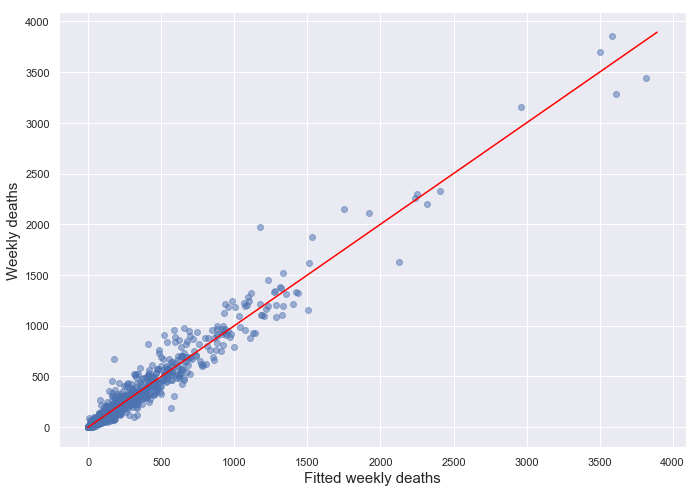

,R squared,RMSE
Fitted,0.959703,67.695275
Cross-Validated,0.939670,70.524278


In [160]:
df_res_lasso_full = get_performance(clf_lasso, scalerY, X_train_lasso, y_train.to_numpy())
df_res_lasso_full

In [161]:
coef_lasso = pd.DataFrame(clf_lasso.coef_, index=X_train_lasso.columns, columns=['Coef']) \
            .reset_index().rename(columns={'index': 'Feature'})
coef_lasso

,Feature,Coef
0,deaths_w1,0.659396
1,deaths_w2,0.084214
2,deaths_w3,-0.032269
3,deaths_w4,-0.021203
4,confirmed_w1,0.176511
5,confirmed_w2,0.071147
6,confirmed_w3,0.125080
7,confirmed_w4,0.048307
8,covid_deaths_old_m1,-0.004251
9,total_deaths_old_m1,0.034167


#### Elastic net

In [162]:
# Elastic net
parameters = {'alpha': np.linspace(0, 0.1, 41),
              'l1_ratio': np.linspace(0, 1, 21)}
model = linear_model.ElasticNet(random_state=42, max_iter=10000)
clf_en_grid = GridSearchCV(model, parameters, cv=5, verbose=1)
clf_en_grid.fit(X_train_lasso, y_train)
clf_en = clf_en_grid.best_estimator_
print(f"best params: {clf_en_grid.best_params_}")

Fitting 5 folds for each of 861 candidates, totalling 4305 fits
best params: {'alpha': 0.0, 'l1_ratio': 0.0}


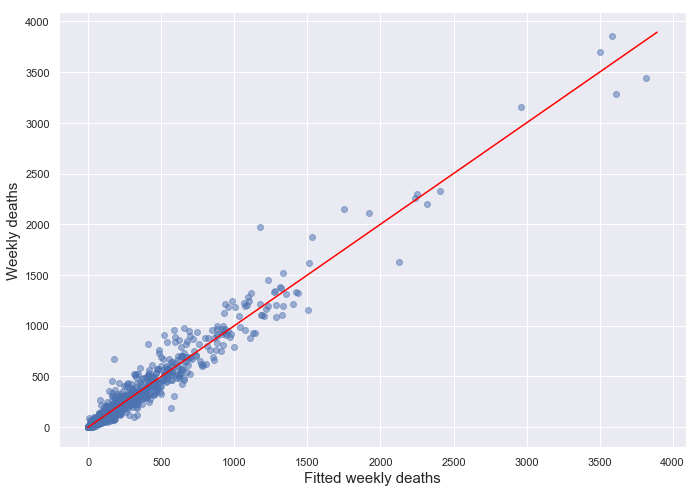

,R squared,RMSE
Fitted,0.959703,67.695275
Cross-Validated,0.939670,70.524278


In [163]:
df_res_en = get_performance(clf_en, scalerY, X_train_lasso, y_train.to_numpy())
df_res_en

In [164]:
pd.DataFrame(clf_en.coef_, index=X_train_lasso.columns)

,0
deaths_w1,0.659396
deaths_w2,0.084214
deaths_w3,-0.032269
deaths_w4,-0.021203
confirmed_w1,0.176511
confirmed_w2,0.071147
confirmed_w3,0.125080
confirmed_w4,0.048307
covid_deaths_old_m1,-0.004251
total_deaths_old_m1,0.034167


#### Random Forest Regression

In [165]:
parameters = {'n_estimators': np.arange(50, 250, 50),
              'max_depth': [10, 20, 50, None]}
model = RandomForestRegressor(random_state=42)
clf_rfr_grid = GridSearchCV(model, parameters, cv=5, verbose=3)
clf_rfr_grid.fit(X_train[lasso_vars], y_train)
clf_rfr = clf_rfr_grid.best_estimator_
clf_rfr

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.867 total time=   0.3s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.916 total time=   0.2s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.836 total time=   0.2s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.944 total time=   0.2s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.952 total time=   0.2s
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.869 total time=   0.4s
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.918 total time=   0.4s
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.847 total time=   0.4s
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=0.945 total time=   0.4s
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.946 total time=   0.4s
[CV 1/5] END ....max_depth=10, n_estimators=150;, score=0.868 total time=   0.6s
[CV 2/5] END ....max_depth=10, n_estimators=150;

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

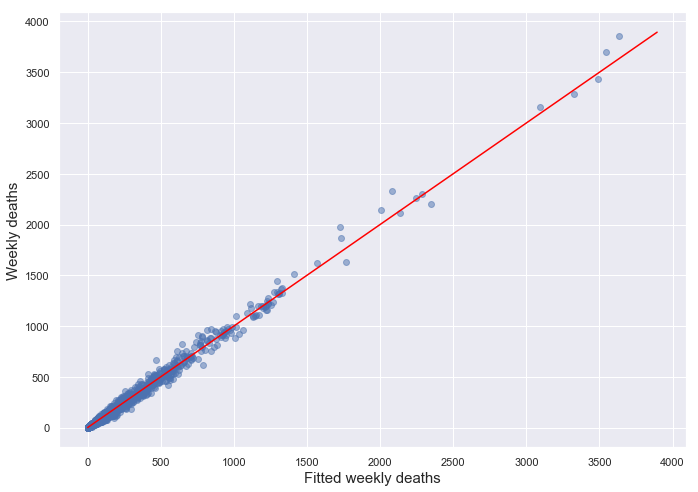

,R squared,RMSE
Fitted,0.991812,30.515188
Cross-Validated,0.906467,104.346573


In [166]:
df_res_rfr = get_performance(clf_rfr, scalerY, X_train[lasso_vars], y_train.to_numpy())
df_res_rfr

This model is clearly overfitted.

#### Gradient Boosted Regressor

In [167]:
from sklearn.ensemble import GradientBoostingRegressor

In [168]:
model.fit(X_train[dcoi_cols], y_train)
parameters = {'n_estimators': np.arange(25, 125, 25)}
model = GradientBoostingRegressor(random_state=42)
clf_gbr_grid = GridSearchCV(model, parameters, cv=5, verbose=3)
clf_gbr_grid.fit(X_train[lasso_vars], y_train)
clf_gbr = clf_gbr_grid.best_estimator_
clf_gbr

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...................n_estimators=25;, score=0.834 total time=   0.0s
[CV 2/5] END ...................n_estimators=25;, score=0.914 total time=   0.0s
[CV 3/5] END ...................n_estimators=25;, score=0.909 total time=   0.0s
[CV 4/5] END ...................n_estimators=25;, score=0.942 total time=   0.0s
[CV 5/5] END ...................n_estimators=25;, score=0.930 total time=   0.0s
[CV 1/5] END ...................n_estimators=50;, score=0.862 total time=   0.0s
[CV 2/5] END ...................n_estimators=50;, score=0.916 total time=   0.0s
[CV 3/5] END ...................n_estimators=50;, score=0.906 total time=   0.1s
[CV 4/5] END ...................n_estimators=50;, score=0.948 total time=   0.1s
[CV 5/5] END ...................n_estimators=50;, score=0.948 total time=   0.1s
[CV 1/5] END ...................n_estimators=75;, score=0.865 total time=   0.2s
[CV 2/5] END ...................n_estimators=75;,

GradientBoostingRegressor(n_estimators=50, random_state=42)

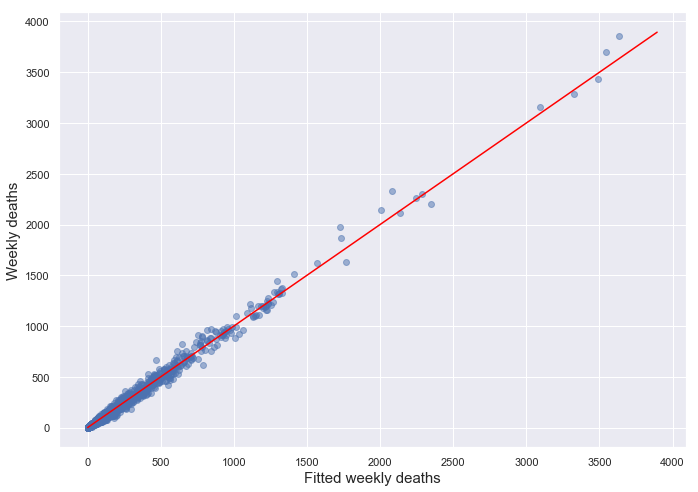

,R squared,RMSE
Fitted,0.991812,30.515188
Cross-Validated,0.906467,104.346573


In [169]:
df_res_gbr = get_performance(clf_rfr, scalerY, X_train[lasso_vars], y_train.to_numpy())
df_res_gbr

Also overfitted!

## Results

#### Train

In [170]:
df_res_dict = OrderedDict()
df_res_dict['Benchmark'] = df_res_bench
df_res_dict['Lin. Reg. with\nLASSO vars'] = df_res_lasso_vars
df_res_dict['Lin. Reg. with\nsig. vars'] = df_res_dcoil
df_res_dict['Ridge\nall vars'] = df_res_rdg_full
df_res_dict['Ridge with\nLASSO vars'] = df_res_rdg_lasso_vars
df_res_dict['LASSO\nall vars'] = df_res_lasso_full
df_res_dict['Elastic Net\nall vars'] = df_res_en
df_res_dict['RF Reg. with\nLASSO vars'] = df_res_rfr
df_res_dict['GB Reg. with\nLASSO vars'] = df_res_gbr

In [171]:
cols = ['Scope', 'Metric', 'Value', 'Model']
df_res = pd.DataFrame(columns=cols)
rename = {'index': 'Scope'}
for model_name, df_res_i in df_res_dict.items():
    df_res_aux = \
    (df_res_i \
         .reset_index()
         .rename(columns=rename)
         .melt(id_vars=rename['index'], var_name='Metric', value_name='Value')
    )
    df_res_aux['Model'] = model_name
    df_res = df_res.append(df_res_aux)
df_res.loc[df_res.Scope == 'Fitted', 'Scope'] = 'Train'
df_res = df_res.reset_index(drop=True)

In [172]:
# Source: https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01, yfactor=0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*yfactor)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [173]:
def plot_performance(df_res, metric, y_label, title, plot_name, y_mult=1, y_axis_delta=0.001, ylim=(0,1), leg_loc='upper left'):
    plt.figure(figsize=(12, 8))
    data_plot = df_res.loc[df_res.Metric == metric]
    data_plot['Value'] = data_plot['Value']*y_mult
    g = sns.barplot(x='Model', y='Value', hue='Scope', palette='Paired', data=data_plot)
    show_values(g, yfactor=y_axis_delta)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim)
    if include_plot_title:
        plt.title(title, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xlabel("Model", fontsize=15)
    plot_name = plot_name.replace(' ', '_')
    plt.savefig(f'{image_folder}{plot_name}.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');

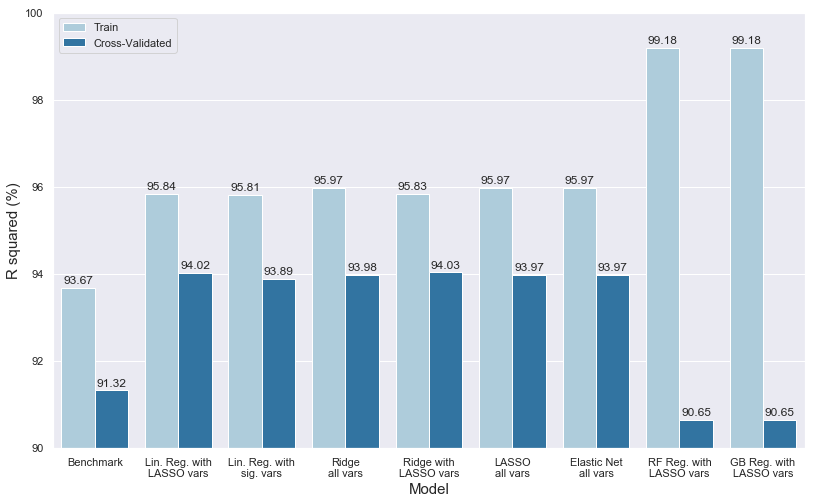

In [174]:
metric = "R squared"
title = f"Train and Cross-Validated {metric} for different models"
plot_performance(df_res, metric, f"{metric} (%)", title, f"results_train_{metric}", y_mult=100, ylim=(90, 100))

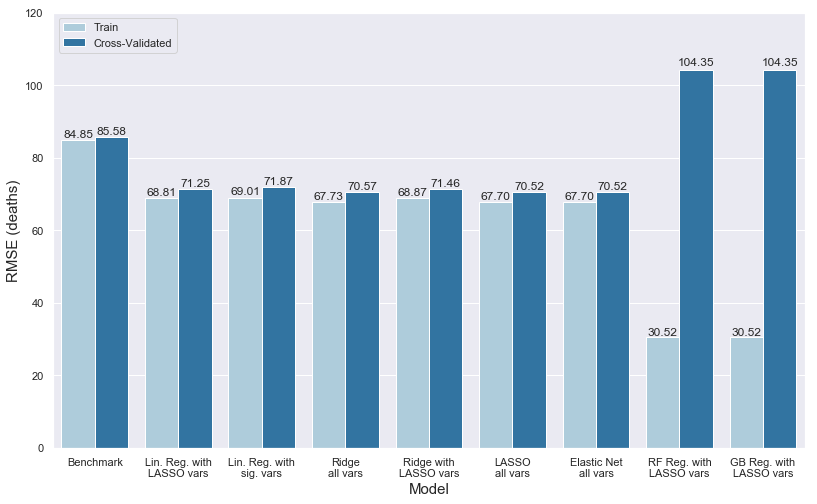

In [175]:
metric = "RMSE"
title = f"Train and Cross-Validated {metric} for different models"
plot_performance(df_res, metric, f"{metric} (deaths)", title, f"results_train_{metric}", y_axis_delta=0.01, ylim=(0, 120))

We decided to choose Ridge regression with LASSO variables as our final model since it had the best performance based on cross-validated R squared score of 94.03\%.

#### Test

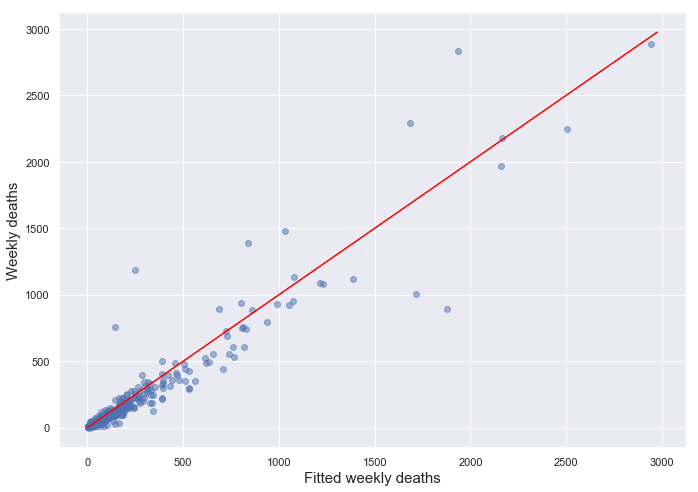

,R squared,RMSE
Fitted,0.884332,137.630270
Cross-Validated,0.814309,161.274985


In [176]:
df_res_rdg_test = get_performance(clf_rdg, scalerY, X_test[lasso_vars], y_test, y_train, plot_file_name="test_ridge_fitted")
df_res_rdg_test

The relevant metric in the above is Fitted, which has to be understood as the test performance. Bit of a misnomer, but CV makes no sense here since it would be fitting the data in the test set.

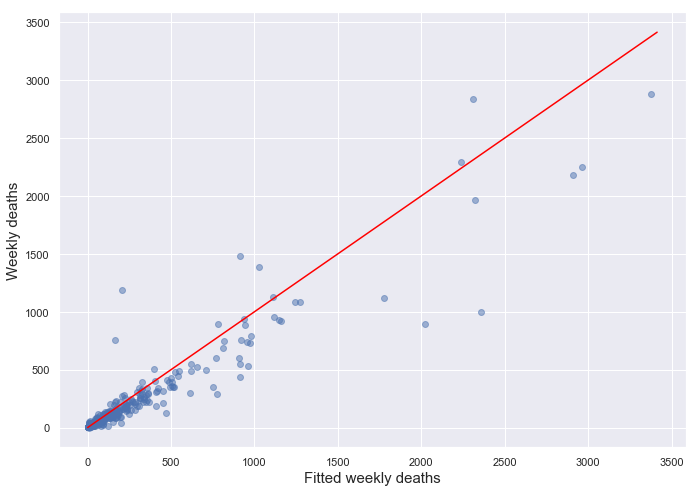

,R squared,RMSE
Fitted,0.809769,176.501819
Cross-Validated,0.830322,143.584423


In [177]:
X0_test = X_test[['deaths_w1']]
df_res_bench_test = get_performance(clf_reg0, scalerY, X0_test, y_test, y_train, plot_file_name="test_bench_fitted")
df_res_bench_test

In [178]:
df_res_test_dict = OrderedDict()
df_res_test_dict['Benchmark'] = df_res_bench_test
df_res_test_dict['Ridge with\nLASSO vars'] = df_res_rdg_test

In [179]:
cols = ['Scope', 'Metric', 'Value', 'Model']
df_res_test = pd.DataFrame(columns=cols)
for model_name, df_res_i in df_res_test_dict.items():
    df_res_aux = \
    (df_res_i \
         .reset_index()
         .rename(columns=rename)
         .melt(id_vars=rename['index'], var_name='Metric', value_name='Value')
    )
    df_res_aux['Model'] = model_name
    df_res_test = df_res_test.append(df_res_aux)
df_res_test = df_res_test.loc[df_res_test.Scope == 'Fitted']
df_res_test.Scope = 'Test'
df_res_test = df_res_test.reset_index(drop=True)

In [180]:
df_res_test

,Scope,Metric,Value,Model
0,Test,R squared,0.809769,Benchmark
1,Test,RMSE,176.501819,Benchmark
2,Test,R squared,0.884332,Ridge with\nLASSO vars
3,Test,RMSE,137.630270,Ridge with\nLASSO vars


In [181]:
df_res_test = df_res.loc[df_res.Model.isin(df_res_test.Model.unique())].append(df_res_test)

In [182]:
df_res_test

,Scope,Metric,Value,Model
0,Train,R squared,0.936697,Benchmark
1,Cross-Validated,R squared,0.913169,Benchmark
2,Train,RMSE,84.846458,Benchmark
3,Cross-Validated,RMSE,85.583463,Benchmark
16,Train,R squared,0.958288,Ridge with\nLASSO vars
17,Cross-Validated,R squared,0.940343,Ridge with\nLASSO vars
18,Train,RMSE,68.873794,Ridge with\nLASSO vars
19,Cross-Validated,RMSE,71.456937,Ridge with\nLASSO vars
0,Test,R squared,0.809769,Benchmark
1,Test,RMSE,176.501819,Benchmark


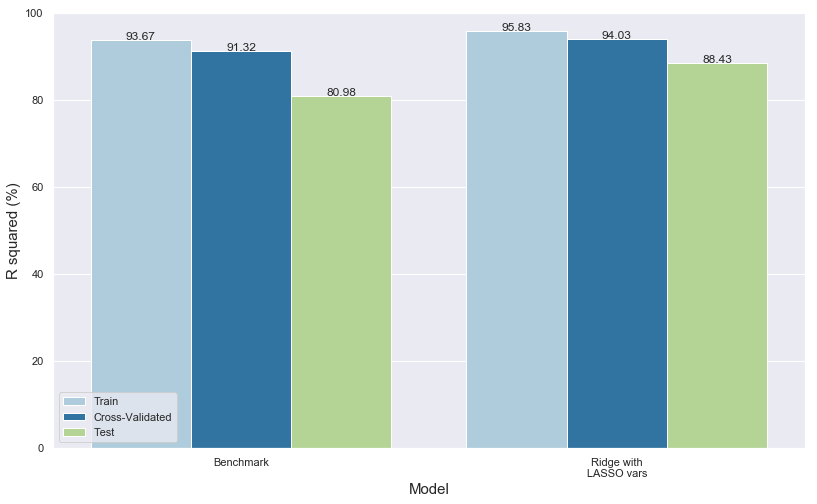

In [183]:
metric = "R squared"
title = f"Train, Cross-Validated and Test {metric} for different models"
plot_performance(df_res_test, metric, f"{metric} (%)", title, f"results_test_{metric}", y_mult=100, ylim=(0, 100), 
                 leg_loc='lower left')

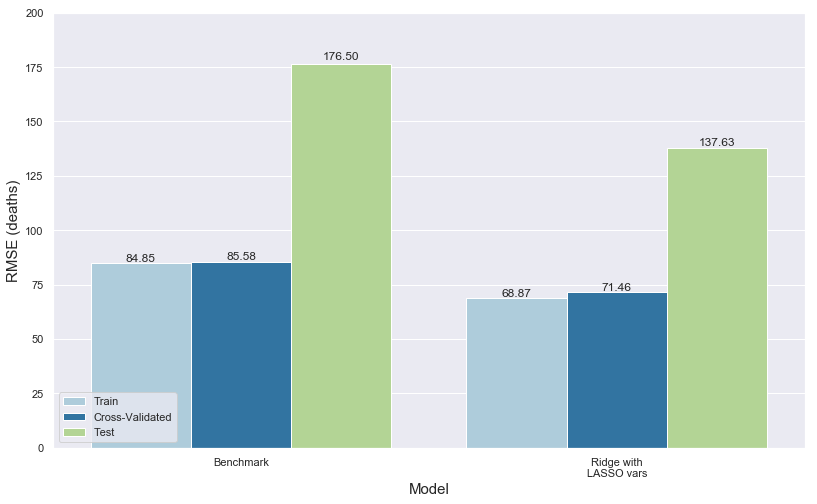

In [184]:
metric = "RMSE"
title = f"Train, Cross-Validated and Test {metric} for different models"
plot_performance(df_res_test, metric, f"{metric} (deaths)", title, f"results_test_{metric}", y_axis_delta=0.01, ylim=(0, 200),
                leg_loc='lower left')

The following plot helps understand that the test set was particularly challenging

In [185]:
df_plot = df_feat.copy()[['state', 'year', 'week', 'week_index', 'date_min', 'deaths']]
week_index_test_start = 41
date_min_test_start = df_plot.loc[df_plot.week_index == week_index_test_start].date_min.unique()[0]
date_min_test_start

numpy.datetime64('2021-02-08T00:00:00.000000000')

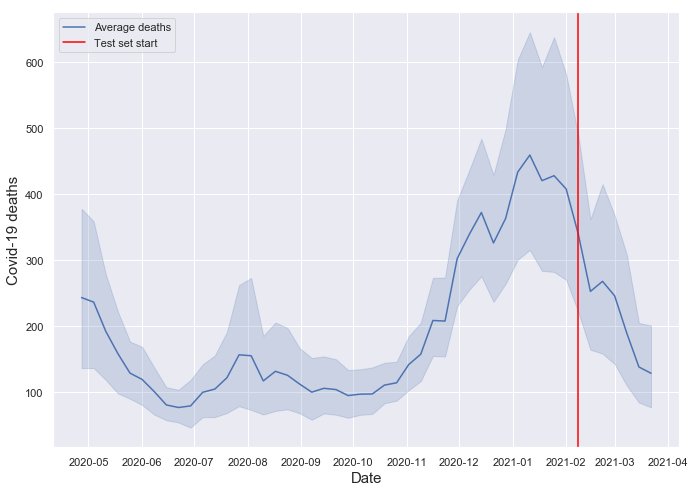

In [186]:
plt.figure(figsize=(10, 8))
sns.lineplot(x='date_min', y='deaths', data=df_plot, label='Average deaths')
plt.axvline(date_min_test_start, 0, df_plot.deaths.max(), label='Test set start', color='red')
if include_plot_title:
    plt.title("Weekly Covid-19 deaths, average between states", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Covid-19 deaths", fontsize=15)
plt.legend()
plt.savefig(f'{image_folder}average_deaths_time_series.jpg', format='jpg', bbox_inches='tight', facecolor='white', 
            edgecolor='none');

## Inference

#### Bootstrapping

We performed boostrapping to discover the empirical distributions for the coefficients. This distributions are well studied in the case of linear regression, but for Ridge regression, our preferred model, the added regularization term can introduce some distortions to the distributions we already have for the linear regression case. 

We use a total of 10,000 simulations. In each simulation we subsample from our data as many times as the number of data points we have, with replacement. We then fit our final Ridge model which has the features obtained using LASSO for feature selection: deaths\_w1, confirmed\_w1, confirmed\_w2, confirmed\_w3, total\_deaths\_old\_m1, deaths\_w1\_influential\_var, and confirmed\_w2\_influential\_var. 

Bootstrapping results can be seen in in the last plot. Feature deaths\_w1 has the largest overall coefficient values, with a  minimum of 0.50. Thus, it is safe to assume that the true coefficient of such a model would be positive and significant. Feature confirmed\_w1, confirmed\_w2, confirmed\_w3, and total\_deaths\_old\_m1 have also a distribution on the positive side with very little chance of the coefficient being equal to 0.

Finally, confirmed\_w2\_influential\_var is likely positive, but there is a chance that it is not-significant based on this methodology. Feature deaths\_w1\_influential\_var is centered very close to 0, making this feature the most likely to be insignificant in the presence of all other features.


In [187]:
m = 10000

In [188]:
X_train_selected = X_train[lasso_vars]
n = X_train_selected.shape[0]
k = X_train_selected.shape[1]
print(n, k)

1683 7


In [189]:
clf_rdg_boot = copy.copy(clf_rdg)
np_coef = np.zeros((m, k))
for j in range(m):
    X_train_sample = X_train_selected.sample(n, replace=True)
    y_train_sample = y_train.loc[X_train_sample.index]
    clf_rdg_boot.fit(X_train_sample, y_train_sample)
    np_coef[j, :] = clf_rdg_boot.coef_

In [190]:
df_coef = pd.DataFrame(np_coef, columns=X_train_selected.columns)
df_coef.describe()

,deaths_w1,confirmed_w1,confirmed_w2,confirmed_w3,total_deaths_old_m1,deaths_w1_influential_var,confirmed_w2_influential_var
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.662583,0.135410,0.111263,0.131225,0.025631,-0.008797,0.030227
std,0.047216,0.068611,0.077890,0.068570,0.008222,0.026705,0.033127
min,0.499398,-0.139185,-0.165669,-0.096252,-0.004795,-0.120512,-0.078569
25%,0.629604,0.088234,0.058262,0.083255,0.020063,-0.026732,0.007276
50%,0.661422,0.135449,0.110241,0.129705,0.025457,-0.008489,0.029925
75%,0.694510,0.182724,0.161482,0.177668,0.031111,0.009303,0.052753
max,0.862874,0.382634,0.387645,0.396797,0.058292,0.082515,0.158262


In [191]:
#In case you need to update seaborn...
#%pip install -U seaborn

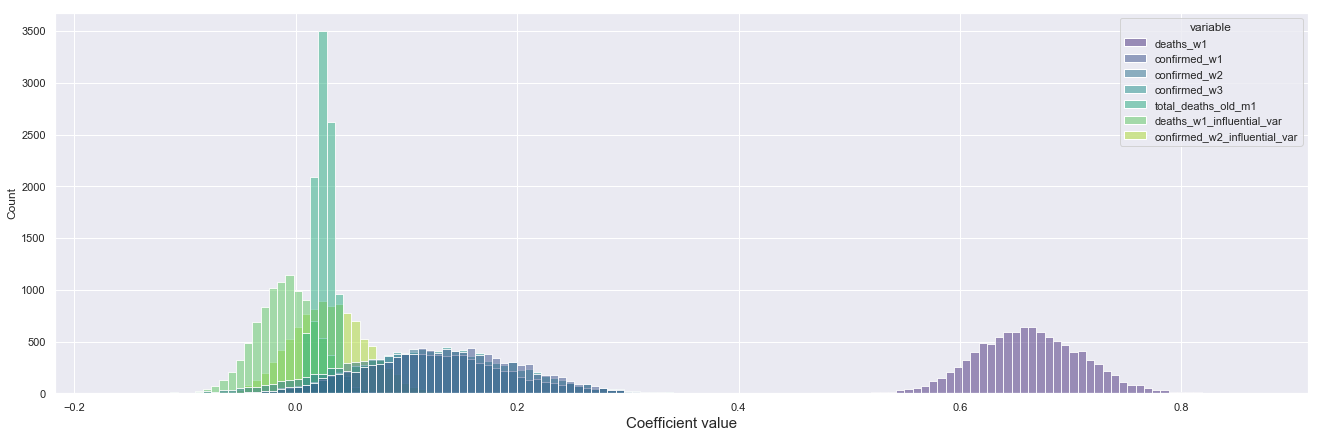

In [192]:
plt.figure(figsize=(20, 7))
sns.histplot(df_coef.melt(), x="value", hue="variable", palette='viridis')
plt.xlabel("Coefficient value", fontsize=15);

In [193]:
plots_per_row = 1
cols = []
for i in range(0, df_coef.shape[1], plots_per_row):
    cols.append(list(df_coef.iloc[:, i:i+plots_per_row].columns))
rows = len(cols)
rows

7

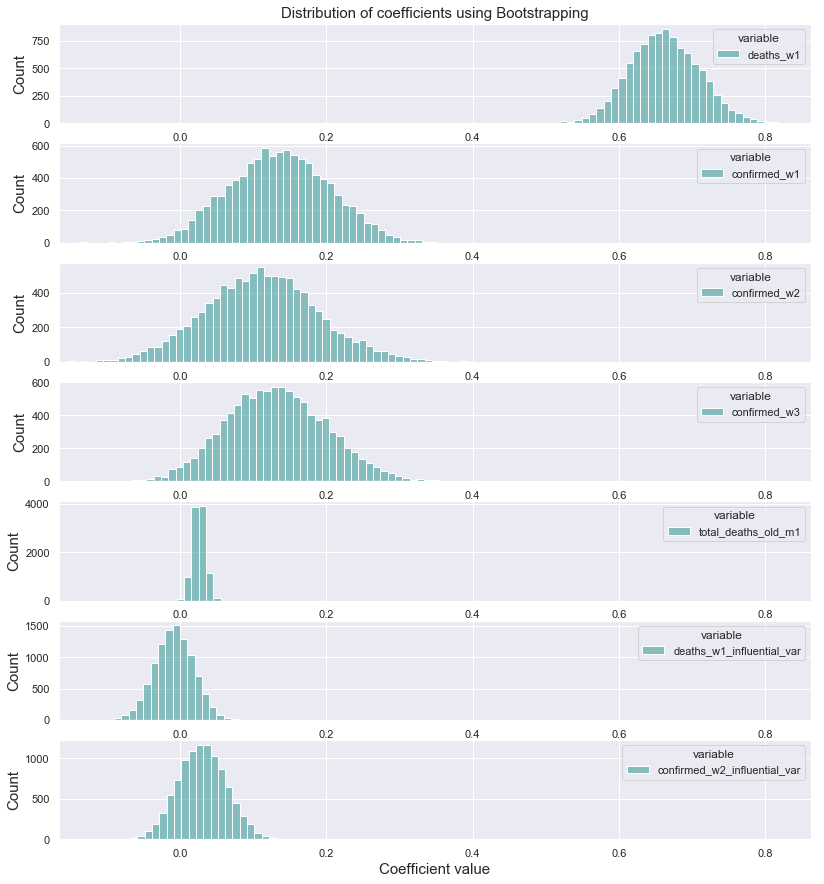

In [194]:
fig, ax = plt.subplots(rows, 1, figsize=(12, 15))
for i in range(rows):
    sns.histplot(df_coef[cols[i]].melt(), x="value", hue="variable", ax=ax[i], binwidth=0.01, palette='viridis')
    ax[i].set_xlim((df_coef.min().min(), df_coef.max().max()))
    ax[i].set_ylabel("Count", fontsize=15)
ax[rows-1].set_xlabel("Coefficient value", fontsize=15)
ax[0].set_title("Distribution of coefficients using Bootstrapping", fontsize=15)
plt.savefig(f'{image_folder}bootstrapping.eps', format='eps', bbox_inches='tight', facecolor='white', edgecolor='none');